# Case study Introduction: Mercari 

#### About company
Mercari is a shopping app which is now operational in Japan, US, and India. It is Japan's biggest community-powered shopping app. Mercari allows users to buy and sell items quickly from their smartphones.

#### Objective
To understand the data, figure out the important features and their impact on the prices of the items by processing the data and performing EDA. And then predicting the price of items.

We will start with importing some important libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gensim
import nltk

# for text processing
from sklearn.feature_extraction.text import CountVectorizer 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer # Word net is a corpus of root words in its simplest form
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from wordcloud import WordCloud

# for encoding
from category_encoders.target_encoder import TargetEncoder

# for tracking run time
from time import time

# for hypothesis testing
from scipy.stats import f_oneway,chi2_contingency, ttest_ind, kstest

# for modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings(action = 'ignore')

In [3]:
eng_stopwords = stopwords.words('english')

In [4]:
# used in removing cleaning text data
def cleaning_function(item):
    item = re.sub("[^A-Za-z0-9 ]","",str(item))
#     text = re.sub("\[rm\] ","",str(text))
    #lower case
    item = item.lower()
    # removal of stopwords
    item = " ".join([i for i in item.split() if i not in eng_stopwords])
    if len(item) == 0: 
        return 'missing'
    else:
        return item

# Generates the wordcloud representation for text data visualization
def word_cloud_generator(feature, text = None):
    plt.figure(figsize = (10,8))
    # since last element of the 'name' mentions the actual type of product
    text_name = " ".join(i.split()[-1] for i in feature)

    word_cloud_name = WordCloud(collocations = False,background_color= 'black').generate(text_name)

    # plotting
    plt.imshow(word_cloud_name, interpolation='bilinear')
    plt.axis("off")
    plt.title(text)

    plt.savefig('most popular tier III category ', bbox_inches = 'tight')
    plt.show()
    
# convert the str of text vector to numerical values using Word2Vec
def sent_to_vec(text_list):
    vec = np.zeros(shape = (300,), dtype = 'float32')
    l = len(text_list)
    for i in text_list:
        try:
            vec += item_and_name_w2v.wv[i]
        except:
            continue
    if l != 0:
        avg_vec = vec/l
        
    return avg_vec

# ks test to check if the two distribution are similar or not.
def ks_test(a,b):
    stst,p_value = kstest(a,b)
    if p_value<0.05:
        print("distribution are different", p_value)
    else:
        print('distribution are similar',p_values)

In [5]:
# reading data
df = pd.read_csv('train.tsv', sep = '\t')
df.head()

train_id                                 name  item_condition_id   
0         0  MLB Cincinnati Reds T Shirt Size XL                  3  \
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price   
0                                  Men/Tops/T-shirts        NaN   10.0  \
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

*train_id* won't be helpful for our current analysis, so we'll be dropping that.

In [6]:
df.drop(['train_id'], axis = 1, inplace = True)

In [7]:
# getting information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   category_name      1476208 non-null  object 
 3   brand_name         849853 non-null   object 
 4   price              1482535 non-null  float64
 5   shipping           1482535 non-null  int64  
 6   item_description   1482529 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 79.2+ MB


In [8]:
# checking % of null values present
df.isnull().sum()*100/df.shape[0]

name                  0.000000
item_condition_id     0.000000
category_name         0.426769
brand_name           42.675687
price                 0.000000
shipping              0.000000
item_description      0.000405
dtype: float64

In [9]:
# checking for duplicates
print("Number of duplicates present: ",df[df.duplicated()].shape[0])

# dropping duplicates
df.drop_duplicates(inplace = True)

Number of duplicates present:  49


**Observations** 
- There are 42.67% null values are present in the column: *brand_name*, which is max for any feature. Features *category_name* and *item_description* have insignificant % of missing values.
- There are only 49 duplicated values present. Since, this number is insignificant, we will drop these rows.

In [10]:
# checking the price statistical values
df['price'].describe()

count    1.482486e+06
mean     2.673804e+01
std      3.858658e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

**Observations** 
- Mean prices 26.73 and median is 17 dollars respectively.

As per the company, items can be priced between $1 - $2000 (https://www.mercari.com/us/help_center/article/69/). Hence, we'll be deleting the rows that doesn't follow the criteria.

In [11]:
print('count of products with 0:', df.loc[df['price'] == 0].shape[0])

df = df.drop(df[(df['price'] < 1.0) | (df['price']> 2000.0)].index)
df.shape

count of products with 0: 874


(1481609, 7)

### Univariate analysis

**1. PRICE**

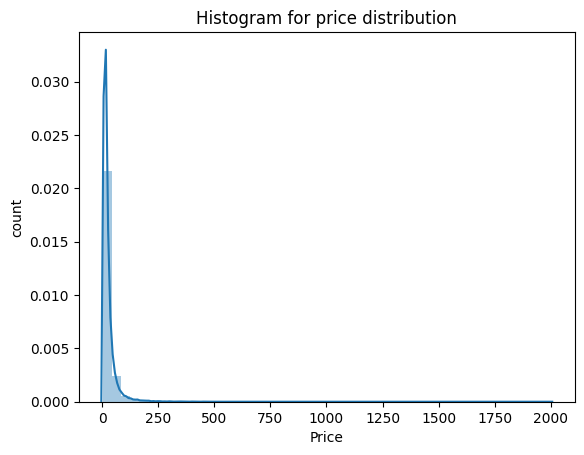

In [12]:
# price distrbution
sns.distplot(df['price'])

plt.title('Histogram for price distribution')
plt.xlabel('Price')
plt.ylabel('count')

plt.savefig('Histogram for price distribution',bbox_inches = 'tight')

plt.show()

The plot appears to be rightly skewed  and looks like log-normal distribution.
Taking the log of the *price* feature will make this distribution to normal.

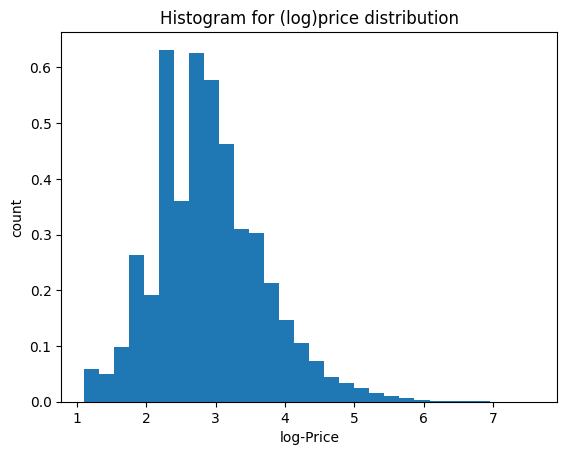

In [13]:
df['log_price'] = df['price'].apply(lambda x: np.log(x))

# visualization
plt.hist(df['log_price'], bins = 30,density = True)


plt.title('Histogram for (log)price distribution')
plt.xlabel('log-Price')
plt.ylabel('count')


plt.savefig('Histogram for (log)price distribution',bbox_inches = 'tight')
plt.show()

Transforming the data from log-normal to gaussian helps in following ways:
1. It helps in performing more statistical tests, as most of test requires data to be normal distributed.
2. Normal distribution helps in better perfromance. For e.g. linear regression, which holds the assumption of dependent variables being normally distributed.

In [14]:
# deleting the price feature having log-normal distribution  to prevent memory space.
df = df.drop('price', axis = 1)

**2. ITEM CONDITION projected by seller**

**How is the item condition distributed among items?**

item_condition_id
1    43.209511
3    29.150201
2    25.323415
4     2.156102
5     0.160771
Name: proportion, dtype: float64


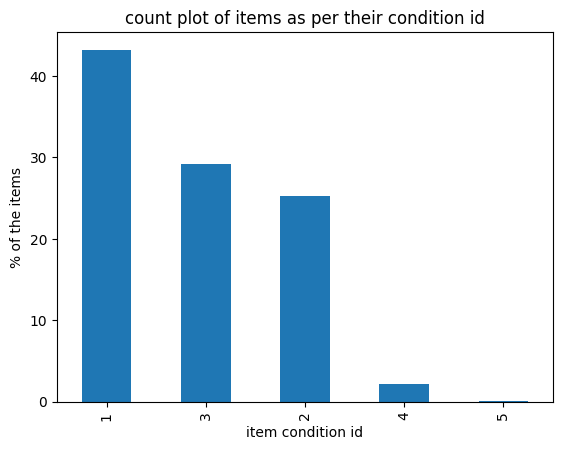

In [15]:
# sellers rating to their products

# percentage of the products with their rating provided by the sellers
print(df['item_condition_id'].value_counts(normalize = True)*100)

((df['item_condition_id'].value_counts(normalize = True))*100).plot(kind= 'bar')
plt.title('count plot of items as per their condition id')
plt.xlabel('item condition id')
plt.ylabel('% of the items')

plt.savefig('count plot of items as per their condition id',bbox_inches = 'tight')
plt.show()

Rating 1 would mean 'excellent' condition of product cause it is condition, most likely the seller would like to state in order for the product to sell. <br> 
<br>Also, any customer would want to buy the prouduct in excellent condition. Hence it is very intuitive that the around 43% of the products are rated as 1, and least (0.16%) products are in real bad condition.

**3. SHIPPING** 

As per the data description: '1' shipping fee is paid by **seller** and '0' means fee is paid by **customer**.

shipping
0    55.26863
1    44.73137
Name: proportion, dtype: float64


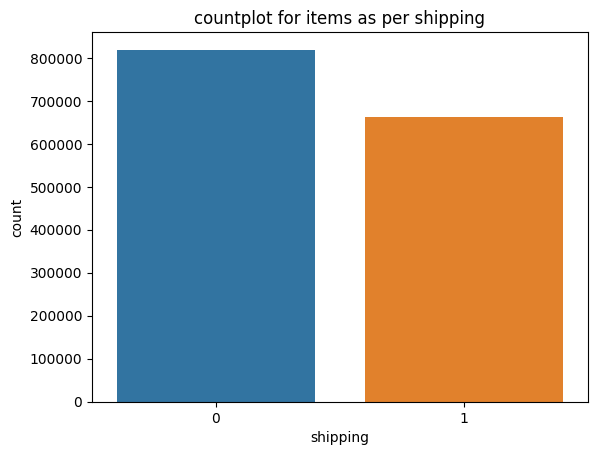

In [16]:
# % distribution of delivery charges between seller and customers
print(df['shipping'].value_counts(normalize = True)*100)

sns.countplot(data = df, x = df['shipping'])
plt.title('countplot for items as per shipping')

plt.savefig('countplot for items as per shipping',bbox_inches = 'tight')
plt.show()

Therefore, around 55% of the times delivery is paid by customers and 44.73% of the times fee is paid by sellers. 

**4. BRANDS**

- There are various brand names possible, but we know that 'nike' and 'NIKE' and 'Nike' are one and same product. We need to remove treat this data so that python takes them as one. 
- We will apply **cleaning_function** that will remove all the punctuations and extra characters, then convert it to lower case and lastly removing all the **stopwords** present in English language using NLTK library.

In [17]:
# applying the 'clean_brand_name' function on the 'brand_name' column
df['clean_brand_name'] = df['brand_name'].apply(cleaning_function)


# dropping original 'brand_name' columns for sake of easy and quick computation
df.drop('brand_name', axis = 1, inplace = True)

In [18]:
print('count of unique brands in the training dataset :', df['clean_brand_name'].nunique())

count of unique brands in the training dataset : 4776


There are 4775 unique brand names present in the dataset. The other one is labelled as 'missing' for all the items with missing brand names.

In [19]:
# distribution of brands in data

print('MOST PoPULAR top 10 brands: ')
print((df['clean_brand_name'].value_counts(normalize = True)*100)[:10])

print()
print()

print('LEAST POPULAR top 10 brands:')
print((df['clean_brand_name'].value_counts(normalize = True)*100)[-10:])

MOST PoPULAR top 10 brands: 
clean_brand_name
nan                 42.676239
pink                 3.649546
nike                 3.645091
victorias secret     3.240396
lularoe              2.091982
apple                1.168594
forever 21           1.024427
nintendo             1.012278
lululemon            0.982040
michael kors         0.939249
Name: proportion, dtype: float64


LEAST POPULAR top 10 brands:
clean_brand_name
tria                    0.000067
donna bella             0.000067
silkies                 0.000067
summer breeze           0.000067
elemis ltd              0.000067
little mistress         0.000067
cypress links           0.000067
hamilton electronics    0.000067
veet                    0.000067
kids                    0.000067
Name: proportion, dtype: float64


Based on the outcomes we can say that, there are 4807 brands  and among those *PINK* , *Nike*, and *Victoria's Secret* are most the popular brands, while *Retro Chic*, *Kische*, and *Kids Only* are the least popular brands.

**5. CATEGORIES**

In [20]:
df['category_name'][:5]

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
Name: category_name, dtype: object

In [21]:
df.dropna(subset = ['category_name'], inplace = True)

In [22]:
df['category_name'] = df['category_name'].str.split('/')

# creating separate columns for each category of the product purchased
df['categ_1'] = df['category_name'].apply(lambda x: x[0])
df['categ_2'] = df['category_name'].apply(lambda x: x[1])
df['categ_3'] = df['category_name'].apply(lambda x: x[2])

# dropping category column
df.drop(['category_name'], axis = 1,inplace = True)

In [23]:
# cleaning all the categories
df['categ_1'] = df['categ_1'].apply(cleaning_function)
df['categ_2'] = df['categ_2'].apply(cleaning_function)
df['categ_3'] = df['categ_3'].apply(cleaning_function)

**What are the main category in which max purchases are being made ?**

categ_1
women                   45.006727
beauty                  14.079218
kids                    11.628454
electronics              8.311897
men                      6.344901
home                     4.597725
vintage collectibles     3.153200
missing                  3.071589
handmade                 2.089887
sports outdoors          1.716402
Name: proportion, dtype: float64


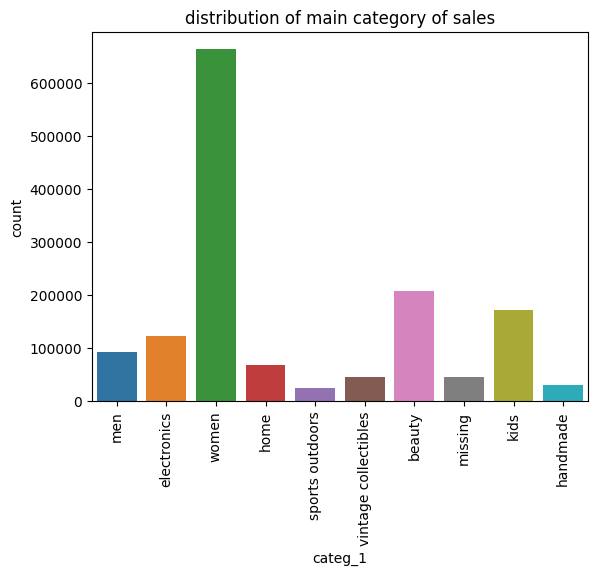

In [24]:
print(df['categ_1'].value_counts(normalize = True)*100)

sns.countplot(data = df, x = 'categ_1')

plt.title('distribution of main category of sales')
plt.xticks(rotation = 90)


plt.savefig('distribution of main category of sales',bbox_inches = 'tight')
plt.show()

Women are most frequent customers and included a major contribution in revenue of the company. But, <br>
<br>
**what are women purchasing the most?**

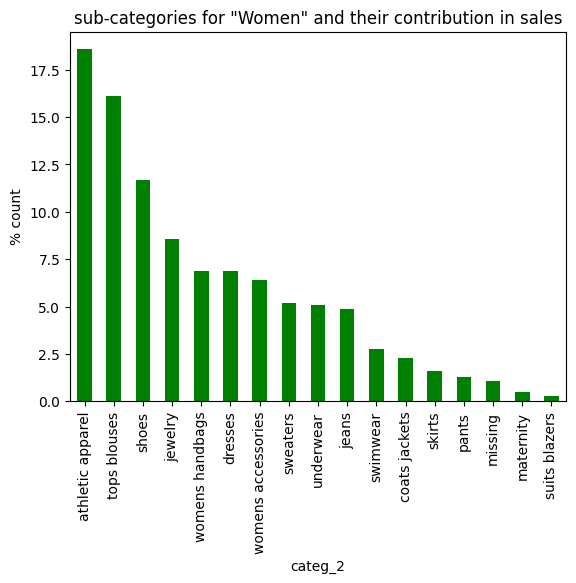

In [25]:
(df.loc[df['categ_1'] == 'women', 'categ_2'].value_counts(normalize = True)*100).plot(kind = 'bar', color = 'green')

plt.title('sub-categories for "Women" and their contribution in sales')
plt.ylabel('% count')

plt.savefig("sub-categories for 'Women' and their contribution in sales",bbox_inches = 'tight')

plt.show()

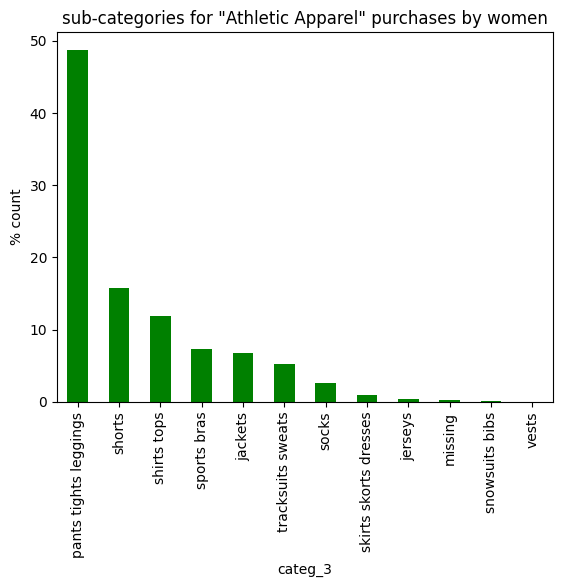

In [26]:
(df.loc[(df['categ_1'] == 'women') & (df['categ_2'] == 'athletic apparel'), 'categ_3'].value_counts(normalize = True)*100).plot(kind = 'bar', color = 'green')

plt.title('sub-categories for "Athletic Apparel" purchases by women')
plt.ylabel('% count')

plt.savefig("sub-categories for 'Athletic Apparel' purchases by women",bbox_inches = 'tight')

plt.show()

This shows that women the primary customers on the platform. Ans they are more into fitness as their purchases are most prominent in *Pants, Tights, Leggings* category. <br>

The second most purchases are made in 'Beauty' category.

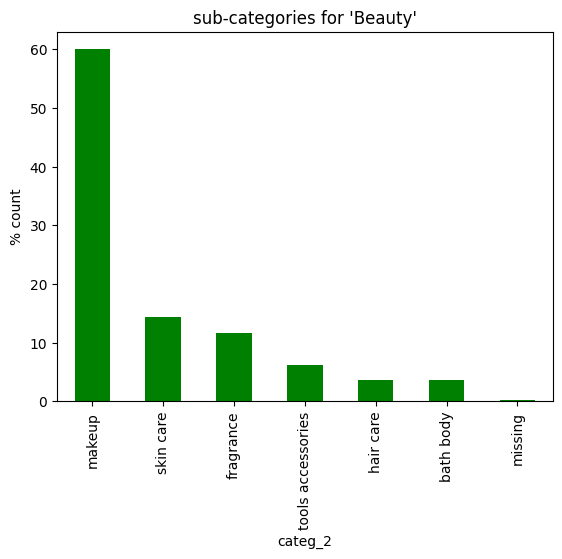

In [27]:
(df.loc[df['categ_1'] == 'beauty', 'categ_2'].value_counts(normalize = True)*100).plot(kind = 'bar', color = 'green')

plt.title("sub-categories for 'Beauty'")
plt.ylabel('% count')

plt.savefig("sub-categories for 'Beauty'",bbox_inches = 'tight')

plt.show()

This shows that women are the most frequent buyers on the platform and their main choices are in clothing and make up.
However, we'll see whether they are the contributing the most in generating revenue as well or nor during bivariate analysis later on.

**What is the most frequent category 2 on the platform**

In [28]:
print('count of sub-category : categ_2 are', df['categ_2'].nunique(),'.')

count of sub-category : categ_2 are 113 .


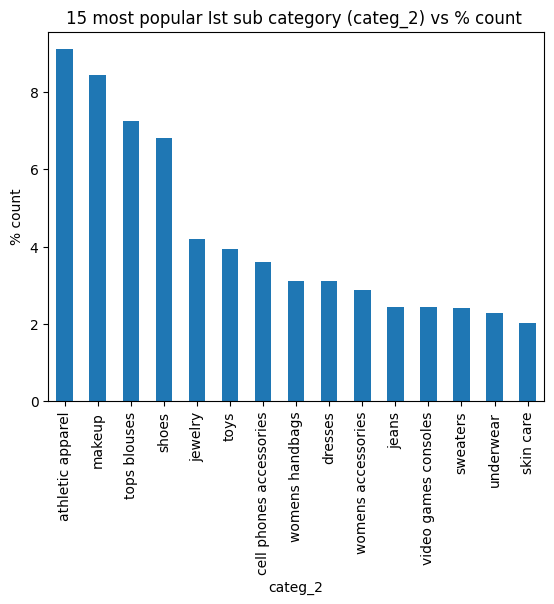

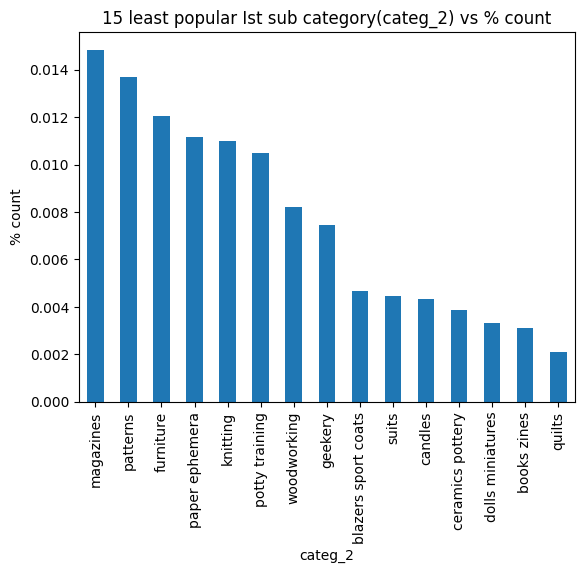

In [29]:
# top 15 most important categ_2
(df['categ_2'].value_counts(normalize = True)[:15]*100).plot(kind = 'bar')
plt.title('15 most popular Ist sub category (categ_2) vs % count ')
plt.ylabel('% count')
plt.savefig('15 most popular Ist sub category (categ_2) vs % count ',bbox_inches = 'tight')
plt.show()


# least popular subcategories
(df['categ_2'].value_counts(normalize = True)[-15:]*100).plot(kind = 'bar')
plt.ylabel('% count')
plt.title('15 least popular Ist sub category(categ_2) vs % count')
plt.savefig("15 most popular Ist sub category (categ_2) vs % count" ,bbox_inches = 'tight')
plt.show()

The plot below make sense, because more frequent buyers are women, and they are very frequent purchasing, Athletic Apparel, Makeup and Tops & Blouses. But apart from women related items (Jewlery, Women's Handbags, Skin Care) there are also products from Electronics, which involves Cell Phones & Accessories, and Video Games & Consoles.

So, *Athletic apparel* is the most popular sub cateogry (categ_2) followed by *makeup* and *Tops and Blouses*. Least popular sub category is *Quilts* followed by *Books and Zines* and *Dolls and Miniatures*.

In [30]:
print('count of unique tier III categories: ',df['categ_3'].nunique())

count of unique tier III categories:  863


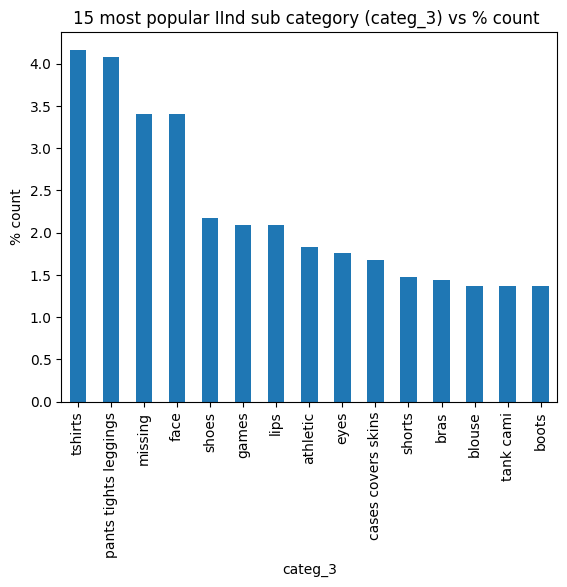

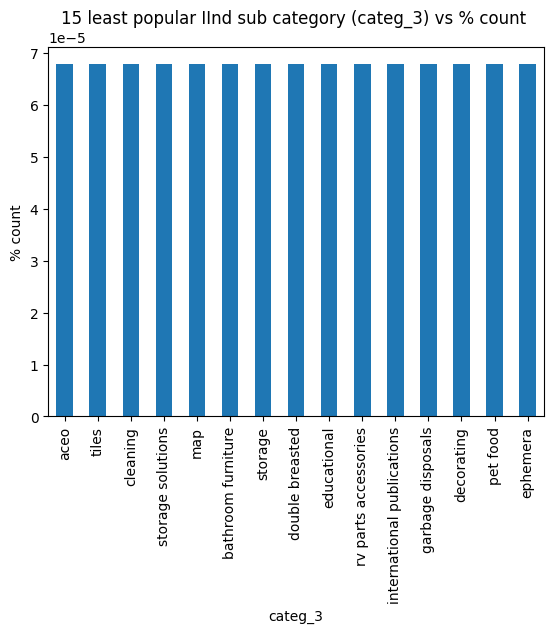

In [31]:
# top 15 most important categ_3
(df['categ_3'].value_counts(normalize = True)[:15]*100).plot(kind = 'bar')
plt.title('15 most popular IInd sub category (categ_3) vs % count ')
plt.ylabel('% count')
plt.savefig('15 most popular IInd sub category (categ_3) vs % count ',bbox_inches = 'tight')
plt.show()


# least popular subcategories
(df['categ_3'].value_counts(normalize = True)[-15:]*100).plot(kind = 'bar')

plt.title('15 least popular IInd sub category (categ_3) vs % count ')
plt.savefig('15 least popular IInd sub category(categ_3)  vs % count ',bbox_inches = 'tight')
plt.ylabel('% count')
plt.show()

In this category *tshirts*  are most popular, followed by  pants thighs and leggings. The least popular category in this feature are pet food and ephemera. 

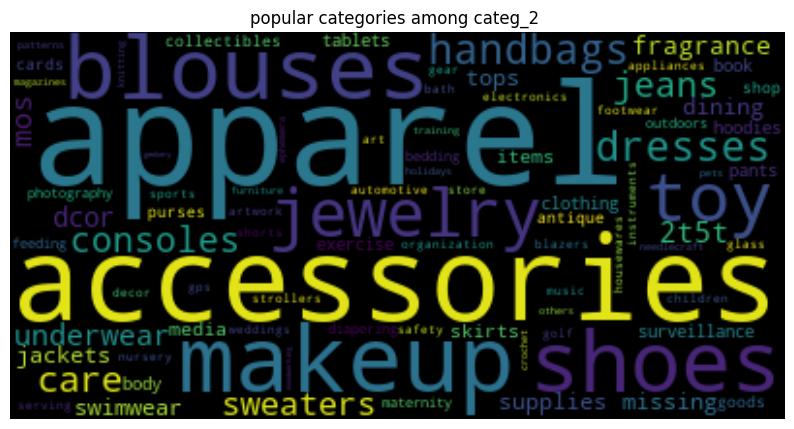

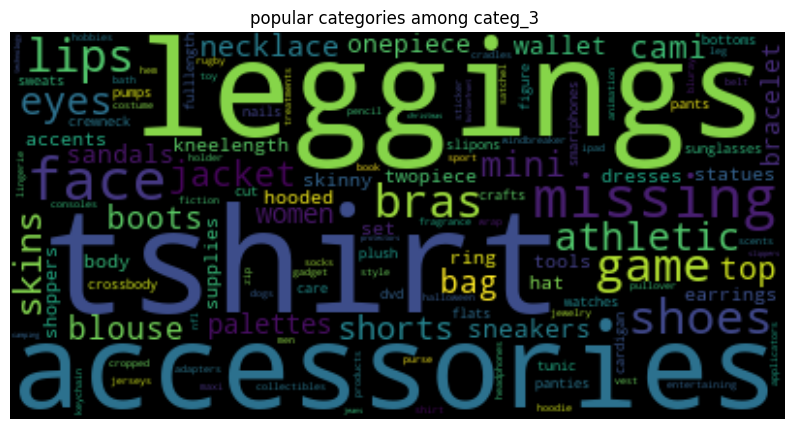

In [32]:
# visualization for 863 unique tier II categories.
word_cloud_generator(df['categ_2'], text = 'popular categories among categ_2 ')


# visualization for 863 unique tier III categories.
word_cloud_generator(df['categ_3'], text = 'popular categories among categ_3 ')

**6. NAME**

In [33]:
print('Total count of unique number of product names: ',df['name'].nunique(),'i.e. around 1.2 million.')

Total count of unique number of product names:  1219512 i.e. around 1.2 million.


Most frequent occcuring word in these names will help in identifying that is popular and in demand. What are the keywords that are helpful in sales.

In [34]:
df['cleaned_name'] = df['name'].apply(cleaning_function)

In [35]:
# top 10 most  sold product name
((df['cleaned_name']).value_counts(normalize = True)*100)[:10]

cleaned_name
bundle                  0.230530
lularoe tc leggings     0.076934
hold                    0.067715
reserved                0.063174
lularoe os leggings     0.061615
coach purse             0.048058
miss jeans              0.047109
american eagle jeans    0.045957
michael kors purse      0.038569
lularoe irma            0.034095
Name: proportion, dtype: float64

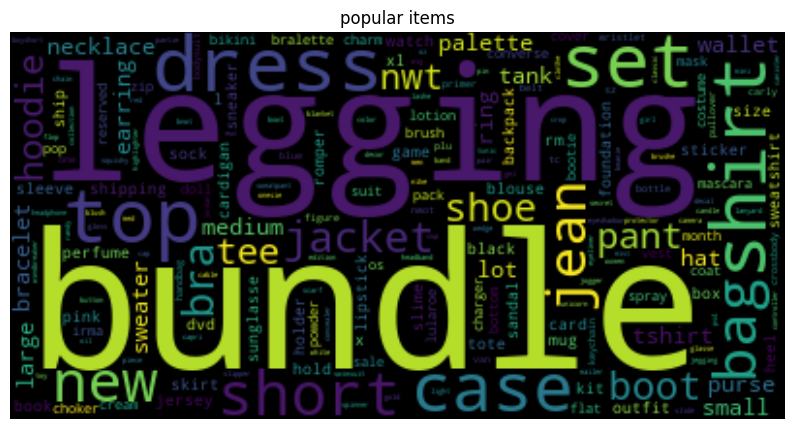

In [36]:
word_cloud_generator(df['cleaned_name'], text = 'popular items')

**7. ITEM DESCRIPTION**

In [37]:
# count of null values present in the item_description column
print( 'count of missing values present in this feature: ',df['item_description'].isna().sum())

count of missing values present in this feature:  6


In [38]:
# treating the text data for the feature
df['clean_item_description'] = df['item_description'].apply(cleaning_function)

now we don't need 'name' and 'item_description' feature in our data.

In [39]:
df1 = df.drop(['name', 'item_description'], axis = 1)

### Bivariate Analysis

**1. log_price - item_condition_id**

In order to know about the price of a product in terms of probablity, we can plot pdfs (kde) and cdfs plots.

In [40]:
df1.groupby('item_condition_id')['log_price'].describe()

count      mean       std       min       25%       50%   
item_condition_id                                                               
1                  637976.0  2.904462  0.811226  1.098612  2.302585  2.890372  \
2                  373019.0  2.937398  0.783390  1.098612  2.397895  2.833213   
3                  430140.0  2.910607  0.760181  1.098612  2.397895  2.772589   
4                   31789.0  2.825687  0.764471  1.098612  2.302585  2.708050   
5                    2371.0  3.032523  0.870259  1.098612  2.397895  2.944439   

                        75%       max  
item_condition_id                      
1                  3.401197  7.600902  
2                  3.367296  7.600902  
3                  3.332205  7.600902  
4                  3.258097  7.177019  
5                  3.569433  6.257668

We can observe, that item with poor condition (item_condition_id = 5) has maximum standard deviation (0.87) and least maximum selling price among all the possible condition id of the products (6.257). we can also observe these facts in boxplot.
<br>
One can also observe that the mean price with item_condition_id = 5, is slightly higher than products with other condition_ids.

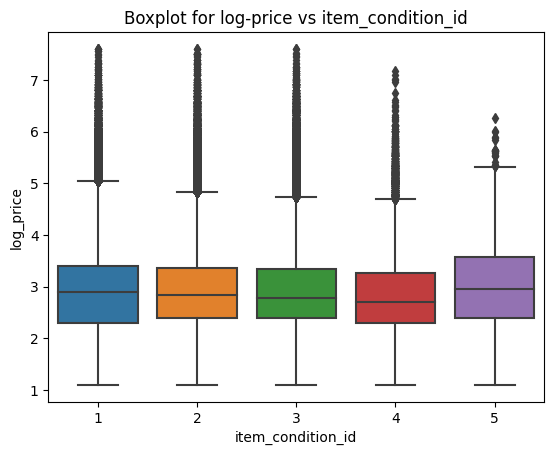

In [41]:
sns.boxplot(x = 'item_condition_id', y = 'log_price', data = df1)
plt.title('Boxplot for log-price vs item_condition_id')
plt.savefig('Boxplot for log-price vs item_condition_id',bbox_inches = 'tight')
plt.show()

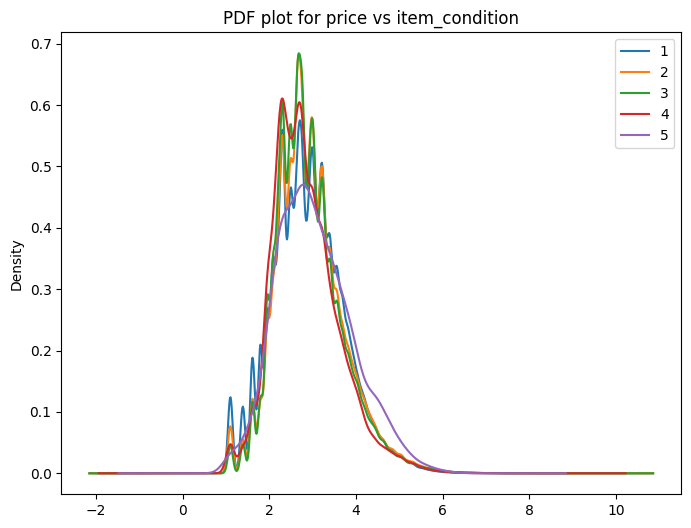

In [42]:
df1.loc[df1['item_condition_id'] == 1,'log_price'].plot(kind = 'kde', label = '1', figsize = (8,6))
df1.loc[df1['item_condition_id'] == 2,'log_price'].plot(kind = 'kde', label = '2', figsize = (8,6))
df1.loc[df1['item_condition_id'] == 3,'log_price'].plot(kind = 'kde', label = '3', figsize = (8,6))
df1.loc[df1['item_condition_id'] == 4,'log_price'].plot(kind = 'kde', label = '4', figsize = (8,6))
df1.loc[df1['item_condition_id'] == 5,'log_price'].plot(kind = 'kde', label = '5', figsize = (8,6))
plt.legend()
plt.title('PDF plot for price vs item_condition')
plt.savefig("PDF plot for price vs item_condition",bbox_inches = 'tight')
plt.show()

Item with condition id = 5 means that the product is in poor condition. And as expected, it has lower proabablity of selling.

**2. clean_brand_name vs log_price**

In [43]:
df_brands =  df1.groupby('clean_brand_name')['log_price'].describe().reset_index()


In [44]:
# statistics for most popular brands (most frequent brands sought by customers in dataset) 

df_brands.sort_values('count', ascending = False)[1:16] # excluding 'missing' brand names

clean_brand_name    count      mean       std       min       25%   
3092              nike  53923.0  3.176703  0.680036  1.098612  2.639057  \
3391              pink  53914.0  3.060937  0.611544  1.098612  2.639057   
4529  victorias secret  47909.0  2.948100  0.592603  1.098612  2.564949   
2660           lularoe  30844.0  3.387463  0.497467  1.386294  3.044522   
249              apple  17285.0  3.412167  1.282128  1.098612  2.397895   
1636        forever 21  15097.0  2.454240  0.453385  1.098612  2.197225   
3102          nintendo  14974.0  3.110302  0.868148  1.098612  2.484907   
2667         lululemon  14540.0  3.676195  0.595894  1.098612  3.295837   
2865      michael kors  13883.0  3.855541  0.763051  1.098612  3.295837   
184     american eagle  13178.0  2.668767  0.439323  1.098612  2.397895   
3565          rae dunn  12270.0  3.406852  0.622235  1.098612  2.944439   
3886           sephora  12153.0  2.836255  0.654164  1.098612  2.397895   
1015             coach  10424.0  3.471059  0.675237  1.098612  2.995732   
451    bath body works  10325.0  2.668077  0.629685  1.098612  2.302585   
1264            disney  10277.0  2.613686  0.614471  1.098612  2.197225   

           50%       75%       max  
3092  3.091042  3.637586  6.129050  
3391  2.995732  3.433987  6.682109  
4529  2.944439  3.295837  7.244228  
2660  3.367296  3.688879  5.857933  
249   3.091042  4.454347  7.554335  
1636  2.484907  2.708050  5.192957  
3102  2.995732  3.583519  6.396930  
2667  3.663562  4.077537  6.566672  
2865  3.891820  4.418841  7.478735  
184   2.639057  2.944439  5.347108  
3565  3.401197  3.806662  6.194405  
3886  2.772589  3.218876  6.418365  
1015  3.433987  3.912023  6.579251  
451   2.639057  3.044522  6.336826  
1264  2.564949  2.995732  6.226537

Earlier we observed that our top consumers were women they were buying *Athletic Apparel* the most. Here also we see that women are primiary customers.
<br>
The same can be observed form above table also.

In [45]:
# the brands with least variance in their prices among the popular brands
df_brands.loc[df_brands['count'] > 10000].sort_values('std')[:15]

clean_brand_name     count      mean       std       min       25%   
184     american eagle   13178.0  2.668767  0.439323  1.098612  2.397895  \
1636        forever 21   15097.0  2.454240  0.453385  1.098612  2.197225   
2660           lularoe   30844.0  3.387463  0.497467  1.386294  3.044522   
4529  victorias secret   47909.0  2.948100  0.592603  1.098612  2.564949   
2667         lululemon   14540.0  3.676195  0.595894  1.098612  3.295837   
3391              pink   53914.0  3.060937  0.611544  1.098612  2.639057   
1264            disney   10277.0  2.613686  0.614471  1.098612  2.197225   
3565          rae dunn   12270.0  3.406852  0.622235  1.098612  2.944439   
451    bath body works   10325.0  2.668077  0.629685  1.098612  2.302585   
3886           sephora   12153.0  2.836255  0.654164  1.098612  2.397895   
1015             coach   10424.0  3.471059  0.675237  1.098612  2.995732   
3092              nike   53923.0  3.176703  0.680036  1.098612  2.639057   
3025               nan  628844.0  2.722889  0.749214  1.098612  2.197225   
2865      michael kors   13883.0  3.855541  0.763051  1.098612  3.295837   
58              adidas   10157.0  3.340831  0.848527  1.098612  2.708050   

           50%       75%       max  
184   2.639057  2.944439  5.347108  
1636  2.484907  2.708050  5.192957  
2660  3.367296  3.688879  5.857933  
4529  2.944439  3.295837  7.244228  
2667  3.663562  4.077537  6.566672  
3391  2.995732  3.433987  6.682109  
1264  2.564949  2.995732  6.226537  
3565  3.401197  3.806662  6.194405  
451   2.639057  3.044522  6.336826  
3886  2.772589  3.218876  6.418365  
1015  3.433987  3.912023  6.579251  
3092  3.091042  3.637586  6.129050  
3025  2.639057  3.178054  7.600902  
2865  3.891820  4.418841  7.478735  
58    3.218876  3.828641  6.856462

Hence, the brands like *American Eagle*, *FOREVER 21*, *LulaRoe*, *Victoria's Secret*, *Lululemon*,*PINK* , *Disney* have the least variation among the popular products.

<Figure size 1000x1800 with 0 Axes>

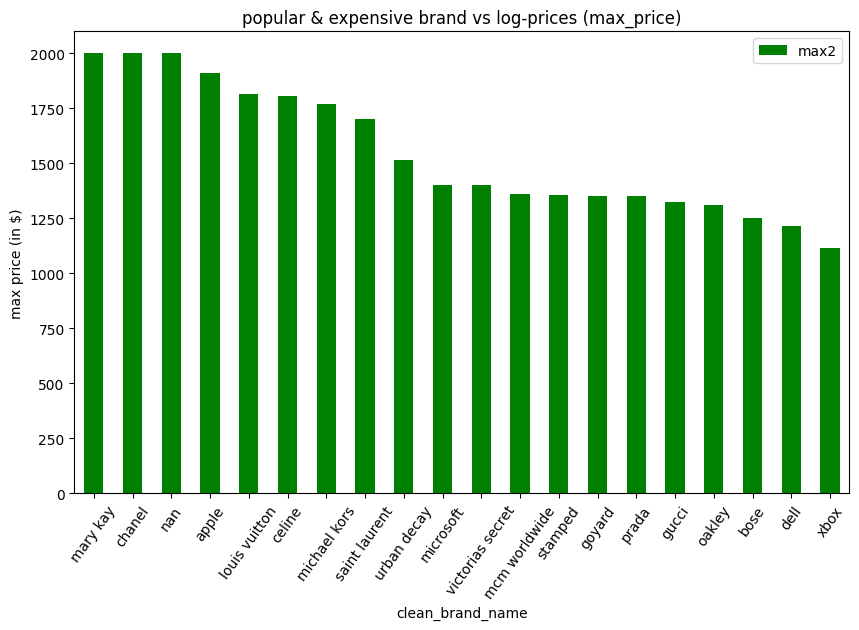

In [46]:
plt.figure(figsize = (10,18))
df_brands['max2'] = df_brands['max'].apply(lambda x: np.exp(x))
pop_and_exp_brands = df_brands[['clean_brand_name','max2']].sort_values('max2' ,ascending = False)[:20].set_index('clean_brand_name')
(pop_and_exp_brands).plot(kind = 'bar', figsize = (10,6), color = 'green')
plt.ylabel('max price (in $)')
plt.xlabel('clean_brand_name')
plt.xticks(rotation = 54)
plt.title("popular & expensive brand vs log-prices (max_price)")


plt.savefig("popular & expensive brand vs log-prices (max_price)",bbox_inches = 'tight')
plt.show()

The most expensive yet popular products are: *Mary Kay*, *Chanel*, *Apple*, *Louis Vuitton*, *Celine* and *Michael Kors*.These popular and expensive brands are likely to generate more revenue for the company.<br>
Next, we'll check the distribution of prices for some of the brands.

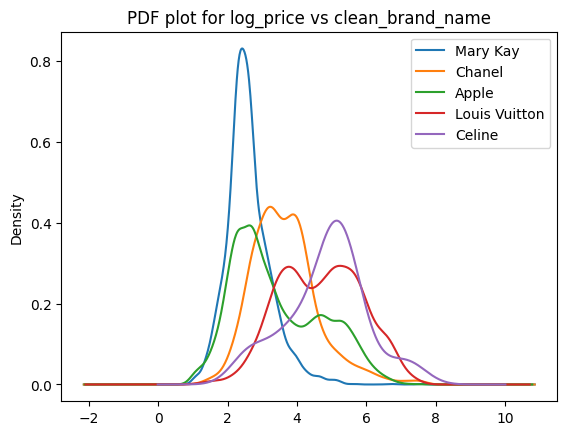

In [47]:
df1.loc[df1['clean_brand_name'] == 'mary kay','log_price'].plot(kind = 'kde', label = 'Mary Kay')
df1.loc[df1['clean_brand_name'] == 'chanel','log_price'].plot(kind = 'kde', label = 'Chanel')
df1.loc[df1['clean_brand_name'] == 'apple','log_price'].plot(kind = 'kde', label = 'Apple')
df1.loc[df1['clean_brand_name'] == 'louis vuitton','log_price'].plot(kind = 'kde', label = 'Louis Vuitton')
df1.loc[df1['clean_brand_name'] == 'celine','log_price'].plot(kind = 'kde', label = 'Celine')
plt.legend()
plt.title('PDF plot for log_price vs clean_brand_name')
plt.savefig('PDF plot for log_price vs clean_brand_name',bbox_inches = 'tight')
plt.show()

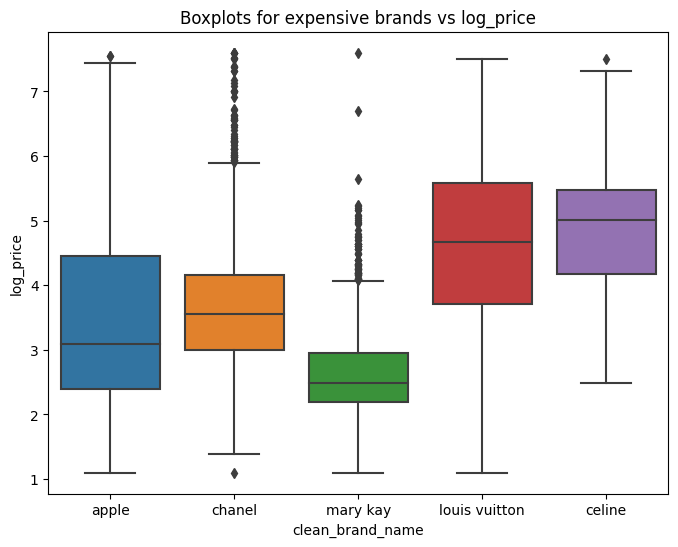

In [48]:
plt.figure(figsize = (8,6))
sns.boxplot(data = df1.loc[df1['clean_brand_name'].isin(['mary kay', 'chanel','apple','louis vuitton','celine'])], x = 'clean_brand_name',y = 'log_price')
plt.title('Boxplots for expensive brands vs log_price')
plt.savefig('Boxplots for expensive brands vs log_price',bbox_inches = 'tight')
plt.show()

- The above plots shows that although the mean of the price of product  by *Mary Kay* is relatively less as compare to other brands, but it has high probablity of being bought. Other products have relatively high variation in the prices of the products they offer. 
- With change in the brand name there is high variation is mean prices of the products. Mary Kay is skin care and make up company, while *Chanel*, *Louis Vuitton* and *Celine* are primarily for clothing. Even then there is considerable difference int their prices. This implies that brand name affects the prices.

In [49]:
df.columns

Index(['name', 'item_condition_id', 'shipping', 'item_description',
       'log_price', 'clean_brand_name', 'categ_1', 'categ_2', 'categ_3',
       'cleaned_name', 'clean_item_description'],
      dtype='object')

**3. Shipping vs log_price**

In [50]:
df1.groupby('shipping')['log_price'].describe()

count      mean       std       min       25%       50%   
shipping                                                               
0         814854.0  3.081486  0.718258  1.704748  2.564949  2.995732  \
1         660441.0  2.705322  0.822007  1.098612  2.197225  2.639057   

               75%       max  
shipping                      
0         3.496508  7.554335  
1         3.218876  7.600902

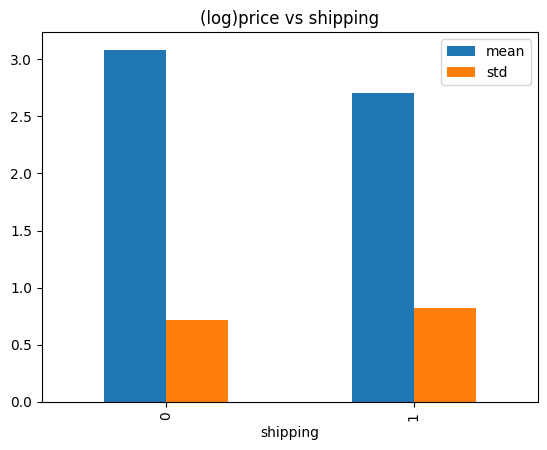

In [51]:
(df1.groupby('shipping')['log_price'].describe())[['mean','std']].plot(kind = 'bar')
plt.title('(log)price vs shipping')
plt.savefig('(log)price vs shipping',bbox_inches = 'tight')
plt.show()

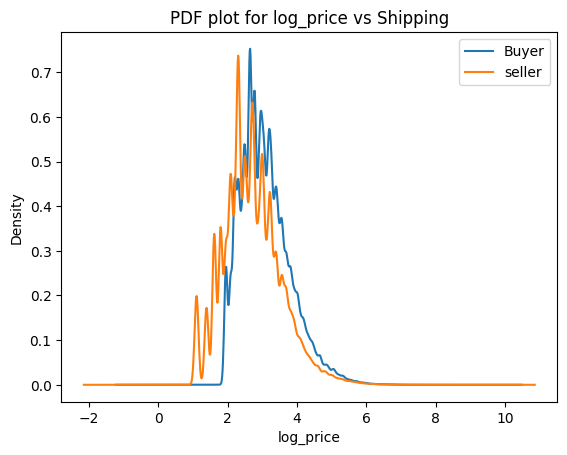

In [52]:
df1.loc[df1['shipping'] == 0,'log_price'].plot(kind = 'kde', label = 'Buyer')
df1.loc[df1['shipping'] == 1,'log_price'].plot(kind = 'kde', label = 'seller')
plt.legend()
plt.title('PDF plot for log_price vs Shipping')
plt.xlabel('log_price')
plt.savefig('PDF plot for log_price vs Shipping',bbox_inches = 'tight')
plt.show()

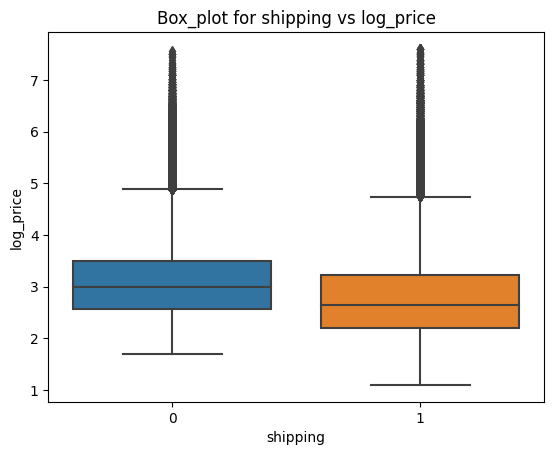

In [53]:
sns.boxplot(data = df1, x = df1['shipping'],y = df1['log_price'])
plt.title('Box_plot for shipping vs log_price')
plt.savefig('Box_plot for shipping vs log_price',bbox_inches = 'tight')
plt.show()

- The mean price for the products where shipping is provided by sellers is less as compared to price of products where shipping is provided by buyers. And this is alright because, if the buyer is paying for both the product and shipping then the final cost of the product will increase.
- However, there is not a siginificant difference in the variance of the prices when shipping is provided by buyer/seller.

**4. categ_1 vs log_prices**

In [54]:
df1.groupby(['categ_1'])['log_price'].describe()

count      mean       std       min       25%   
categ_1                                                                  
beauty                207710.0  2.724877  0.676139  1.098612  2.302585  \
electronics           122625.0  2.913198  0.993551  1.098612  2.197225   
handmade               30832.0  2.473235  0.853699  1.098612  1.791759   
home                   67830.0  2.928214  0.703043  1.098612  2.484907   
kids                  171554.0  2.737524  0.705351  1.098612  2.302585   
men                    93606.0  3.178475  0.798346  1.098612  2.639057   
missing                45315.0  2.670250  0.778933  1.098612  2.197225   
sports outdoors        25322.0  2.907715  0.755203  1.098612  2.397895   
vintage collectibles   46519.0  2.820114  0.877506  1.098612  2.302585   
women                 663982.0  3.022067  0.763747  1.098612  2.484907   

                           50%       75%       max  
categ_1                                             
beauty                2.708050  3.178054  7.600902  
electronics           2.708050  3.433987  7.554335  
handmade              2.484907  2.995732  7.467371  
home                  2.890372  3.367296  6.742881  
kids                  2.639057  3.178054  6.695799  
men                   3.044522  3.688879  7.177019  
missing               2.639057  3.135494  7.244228  
sports outdoors       2.772589  3.332205  6.818924  
vintage collectibles  2.772589  3.295837  7.443664  
women                 2.944439  3.526361  7.600902

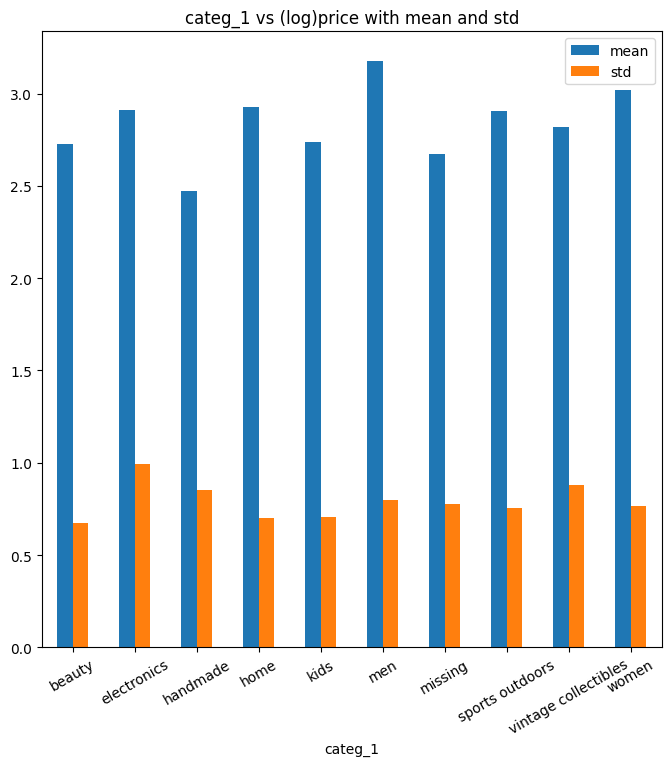

In [55]:
(df1.groupby(['categ_1'])['log_price'].describe())[['mean','std']].plot(kind = 'bar', figsize = (8,8))
plt.title('categ_1 vs (log)price with mean and std')
plt.xticks(rotation  = 30)
plt.savefig('categ_1 vs (log)price with mean and std',bbox_inches = 'tight')
plt.show()

In [56]:
df1['categ_1'].value_counts(normalize = True)*100

categ_1
women                   45.006727
beauty                  14.079218
kids                    11.628454
electronics              8.311897
men                      6.344901
home                     4.597725
vintage collectibles     3.153200
missing                  3.071589
handmade                 2.089887
sports outdoors          1.716402
Name: proportion, dtype: float64

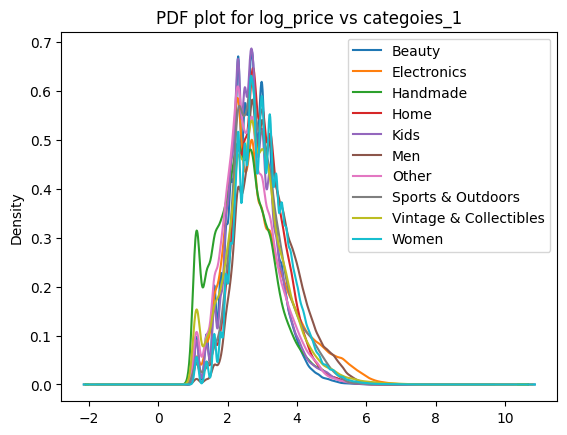

In [57]:
df1.loc[df1['categ_1'] == 'beauty','log_price'].plot(kind = 'kde', label = 'Beauty')
df1.loc[df1['categ_1'] == 'electronics','log_price'].plot(kind = 'kde', label = 'Electronics')
df1.loc[df1['categ_1'] == 'handmade','log_price'].plot(kind = 'kde', label = 'Handmade')
df1.loc[df1['categ_1'] == 'home','log_price'].plot(kind = 'kde', label = 'Home')
df1.loc[df1['categ_1'] == 'kids','log_price'].plot(kind = 'kde', label = 'Kids')
df1.loc[df1['categ_1'] == 'men','log_price'].plot(kind = 'kde', label = 'Men')
df1.loc[df1['categ_1'] == 'missing','log_price'].plot(kind = 'kde', label = 'Other')
df1.loc[df1['categ_1'] == 'sports outdoors','log_price'].plot(kind = 'kde', label = 'Sports & Outdoors')
df1.loc[df1['categ_1'] == "vintage collectibles",'log_price'].plot(kind = 'kde', label = 'Vintage & Collectibles')
df1.loc[df1['categ_1'] == 'women','log_price'].plot(kind = 'kde', label = 'Women')
plt.legend()
plt.title('PDF plot for log_price vs categoies_1')
plt.savefig('PDF plot for log_price vs categoies_1',bbox_inches = 'tight')
plt.show()

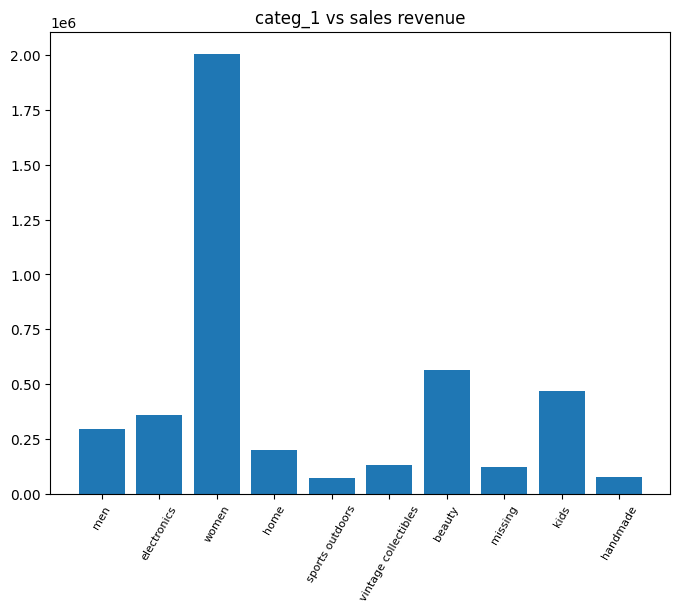

In [58]:
# in terms of revenue
plt.figure(figsize = (8,6))

categ_1_names = pd.Series(df1['categ_1'].unique())
revenue_categ_1 = []
for i in categ_1_names:
    revenue_categ_1.append(round(df1.loc[df1['categ_1'] == i, 'log_price'].sum(),3))
revenue_categ_1 = pd.Series(revenue_categ_1)

s_df = pd.concat([categ_1_names, revenue_categ_1], axis = 1)
s_df.columns = ['categ_1', 'total sales price']

plt.bar(s_df['categ_1'], s_df['total sales price'])
plt.title('categ_1 vs sales revenue')
plt.xticks(rotation = 60, fontsize = 8)
plt.savefig('categ_1 vs sales revenue',bbox_inches = 'tight')

plt.show()

- Although, women are frequent buyers the mean of the purchases of males is slighlty greated over women. 
- The variance in the prices was highest in *Electronics* followed by *Vintage & Collectibles* and least in *Beauty* followed by *Home*.
- This can also be observed that among all the categories there is not much difference in their mean and standard deviations for the purchases.
- Another observation that can be made is that products of almost all the categories lying in fixed range. Except, *Handmade* products, which has least mean  of all categories and high variance.

**5. categ_2 vs log_prices**

In [59]:
print('count of unique sub_categories: ', df1['categ_2'].nunique())

# most popular subcategories 1
(df1['categ_2'].value_counts(normalize = True)*100)[:10]

count of unique sub_categories:  113


categ_2
athletic apparel           9.104620
makeup                     8.442854
tops blouses               7.245331
shoes                      6.804334
jewelry                    4.184045
toys                       3.939077
cell phones accessories    3.610532
womens handbags            3.106226
dresses                    3.099719
womens accessories         2.868986
Name: proportion, dtype: float64

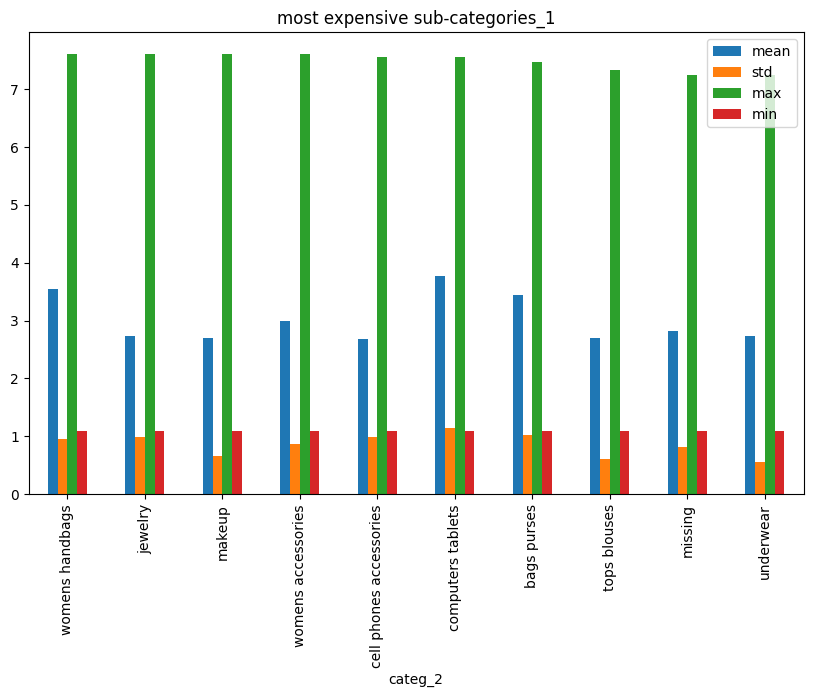

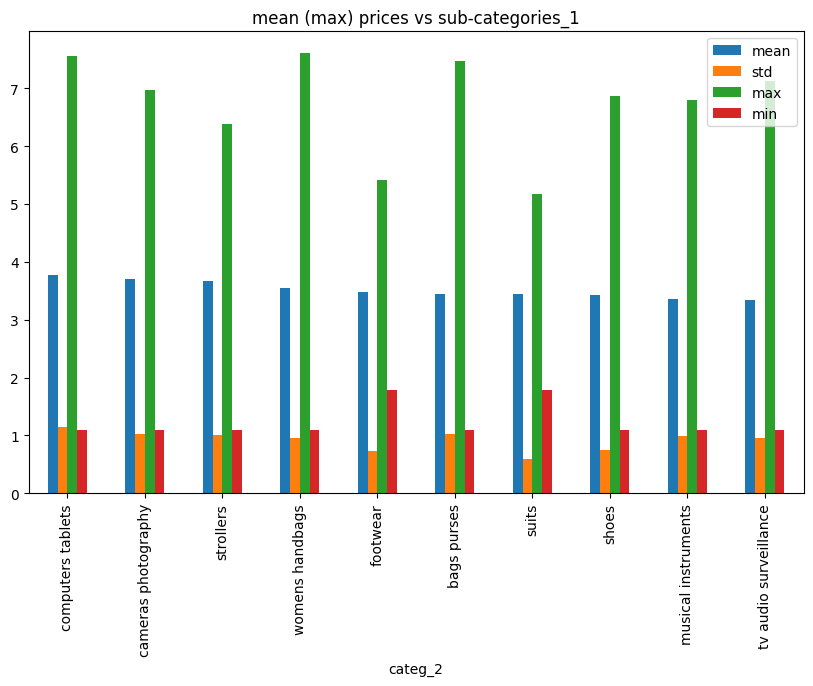

In [60]:
# most expensive products
(df1.groupby('categ_2')['log_price'].describe())[['mean','std','max','min']].sort_values('max', ascending = False)[:10].plot(kind = 'bar', figsize = (10,6), title=  'most expensive sub-categories_1')
plt.xticks(rotation = 90)
plt.savefig('most expensive sub-categories_1',bbox_inches = 'tight')
plt.show()


# mean prices products
(df1.groupby('categ_2')['log_price'].describe())[['mean','std','max','min']].sort_values('mean', ascending = False)[:10].plot(kind = 'bar', figsize = (10,6), title=  'mean (max) prices vs sub-categories_1')
plt.xticks(rotation = 90)
plt.savefig('mean (max) prices vs sub-categories_1',bbox_inches = 'tight')
plt.show()

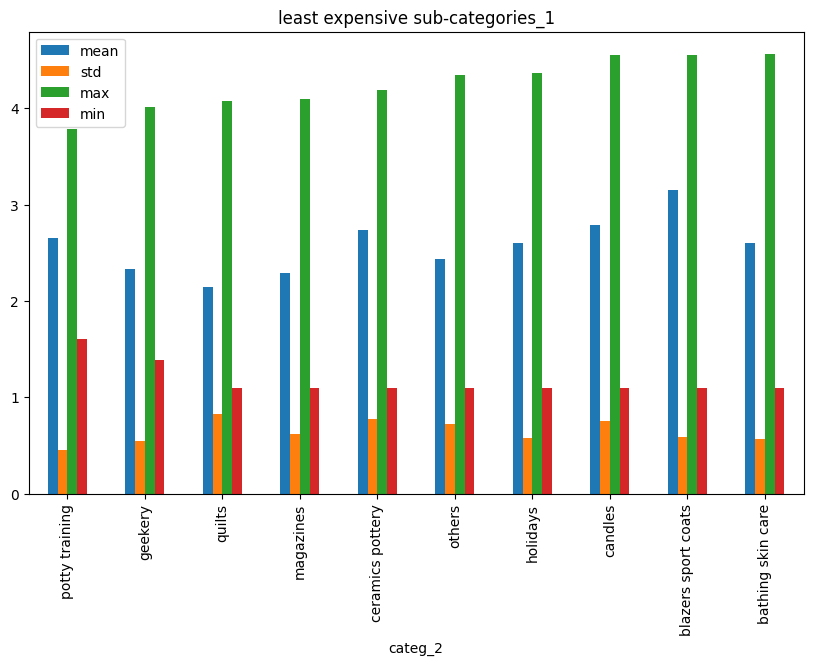

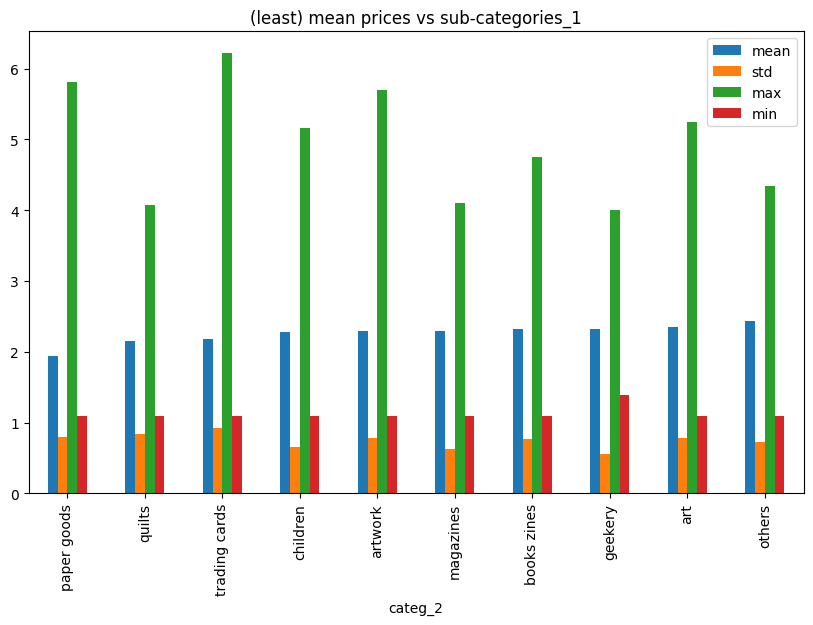

In [61]:
# least expensive products
(df1.groupby('categ_2')['log_price'].describe())[['mean','std','max','min']].sort_values('max', ascending = True)[:10].plot(kind = 'bar', figsize = (10,6), title=  'least expensive sub-categories_1')
plt.savefig('least expensive sub-categories_1',bbox_inches = 'tight')
plt.show()


# mean_prices 
(df1.groupby('categ_2')['log_price'].describe())[['mean','std','max','min']].sort_values('mean', ascending = True)[:10].plot(kind = 'bar', figsize = (10,6), title=  '(least) mean prices vs sub-categories_1')
plt.savefig('(least) mean prices vs sub-categories_1',bbox_inches = 'tight')
plt.show()

- Mean prices may differ in various sub categories but max prices among all categories are almost same.

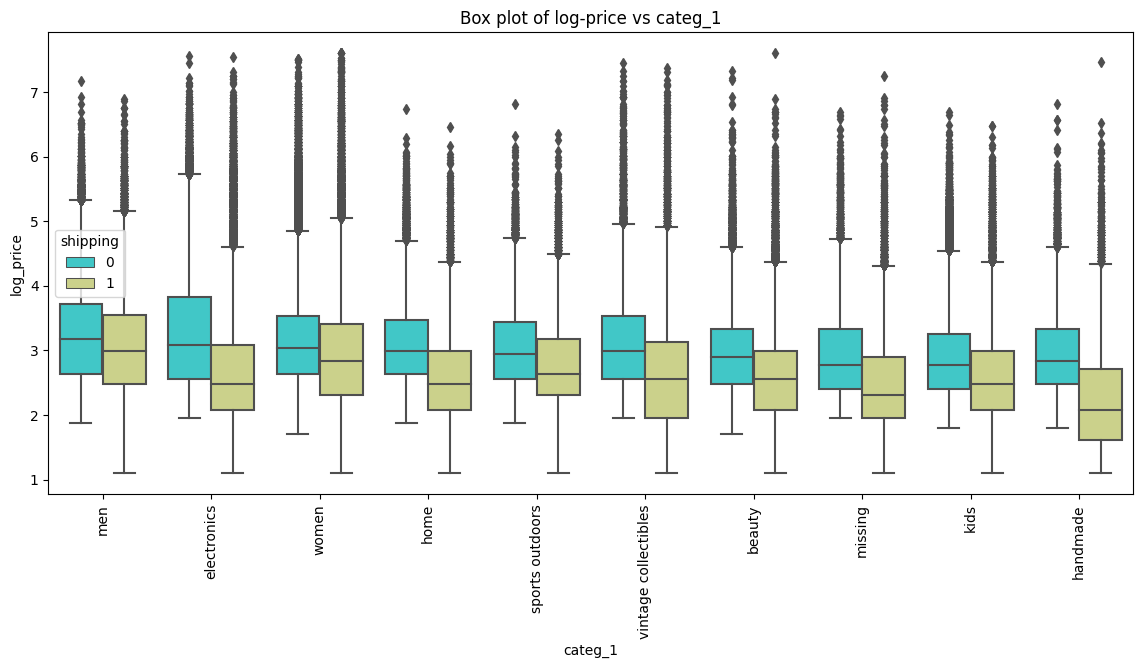

In [62]:
plt.figure(figsize=(14,6))
sns.boxplot(x='categ_1', y="log_price",hue='shipping',data=df1,palette='rainbow')
plt.title('Box plot of log-price vs categ_1')
plt.xticks(rotation = 90)
plt.savefig("Box plot of log-price vs categ_1 for different shipping",bbox_inches = 'tight')

**6. categ_3 vs log_prices**

In [63]:
print('count of unique sub_categories: ', df1['categ_2'].nunique())

# most popular subcategories 2
(df1['categ_3'].value_counts(normalize = True)*100)[:10]

count of unique sub_categories:  113


categ_3
tshirts                  4.164726
pants tights leggings    4.077218
missing                  3.403590
face                     3.398642
shoes                    2.178412
games                    2.094090
lips                     2.091717
athletic                 1.832650
eyes                     1.763512
cases covers skins       1.672005
Name: proportion, dtype: float64

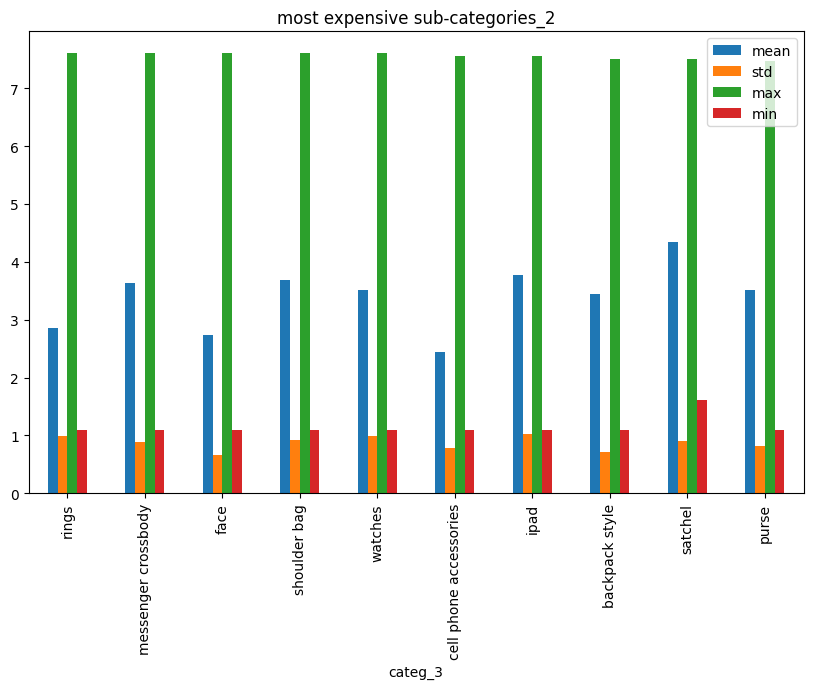

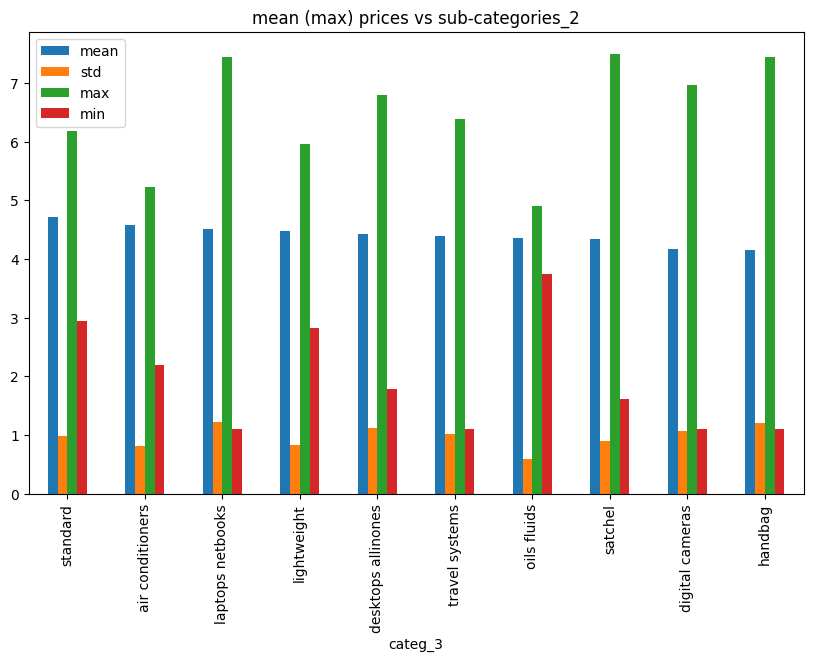

In [64]:
# most expensive products
(df1.groupby('categ_3')['log_price'].describe())[['mean','std','max','min']].sort_values('max', ascending = False)[:10].plot(kind = 'bar', figsize = (10,6), title=  'most expensive sub-categories_2')
plt.xticks(rotation = 90)
plt.savefig('most expensive sub-categories_2',bbox_inches = 'tight')
plt.show()


# mean prices products
(df1.groupby('categ_3')['log_price'].describe())[['mean','std','max','min']].sort_values('mean', ascending = False)[:10].plot(kind = 'bar', figsize = (10,6), title=  'mean (max) prices vs sub-categories_2')
plt.xticks(rotation = 90)
plt.savefig('mean (max) prices vs sub-categories_2',bbox_inches = 'tight')
plt.show()

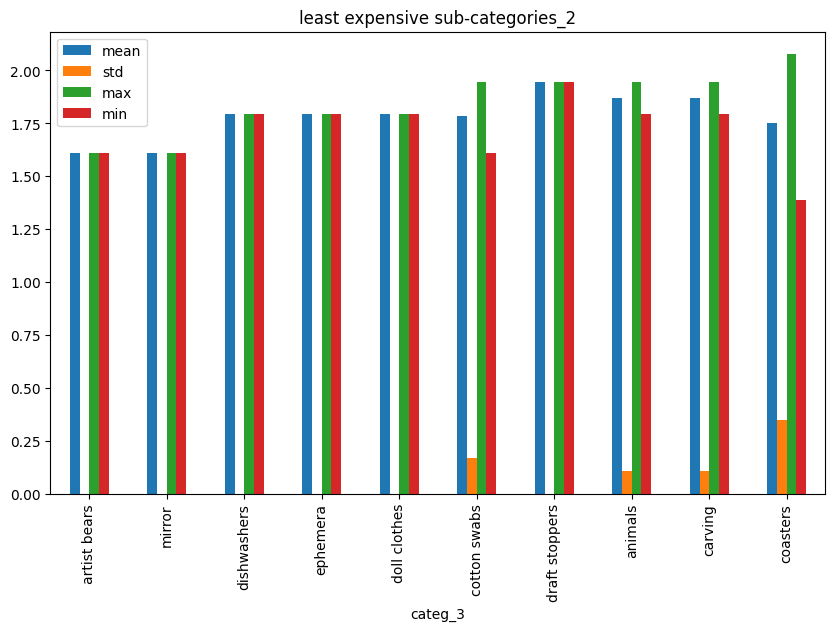

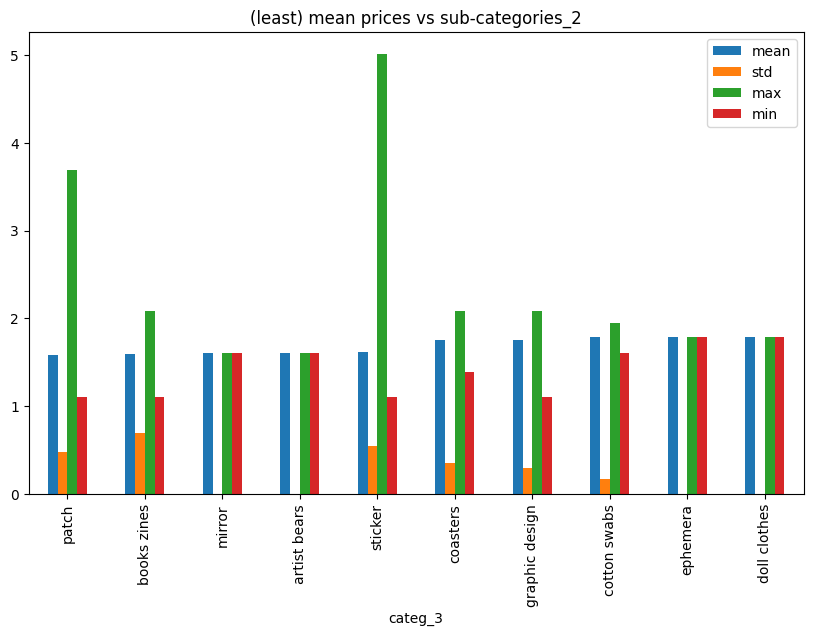

In [65]:
# least expensive products
(df1.groupby('categ_3')['log_price'].describe())[['mean','std','max','min']].sort_values('max', ascending = True)[:10].plot(kind = 'bar', figsize = (10,6), title=  'least expensive sub-categories_2')
plt.savefig('least expensive sub-categories_2',bbox_inches = 'tight')
plt.show()


# mean_prices 
(df1.groupby('categ_3')['log_price'].describe())[['mean','std','max','min']].sort_values('mean', ascending = True)[:10].plot(kind = 'bar', figsize = (10,6), title=  '(least) mean prices vs sub-categories_2')
plt.savefig('(least) mean prices vs sub-categories_2',bbox_inches = 'tight')
plt.show()

**What are the popular items among buyers with different condition id?**

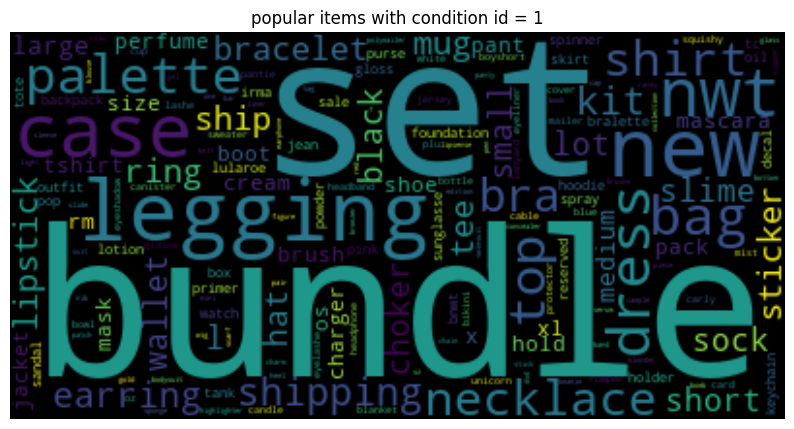

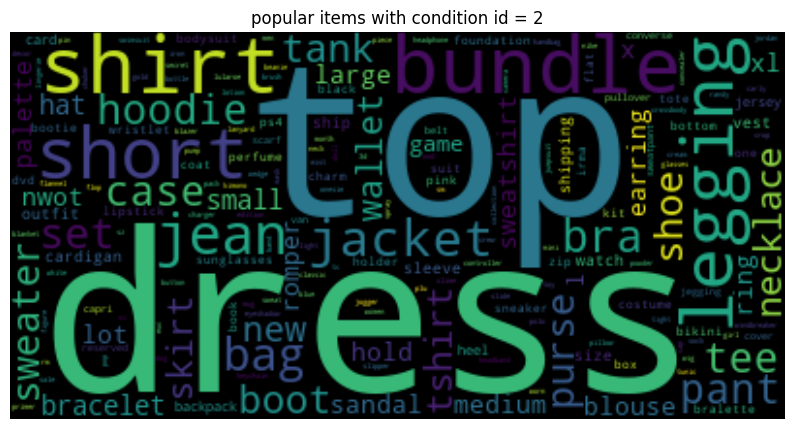

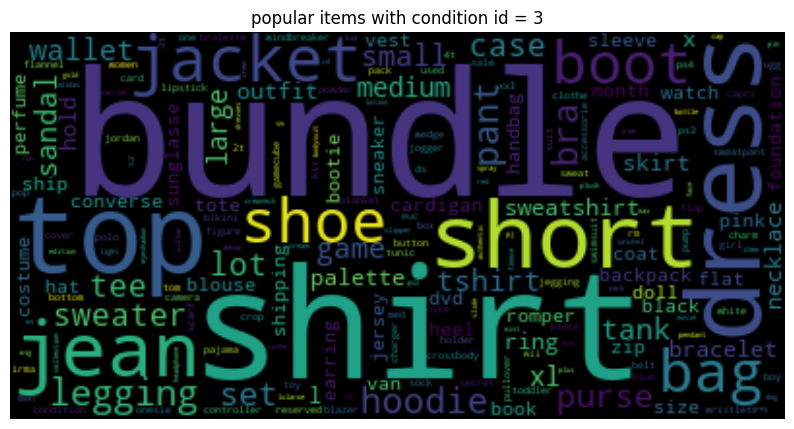

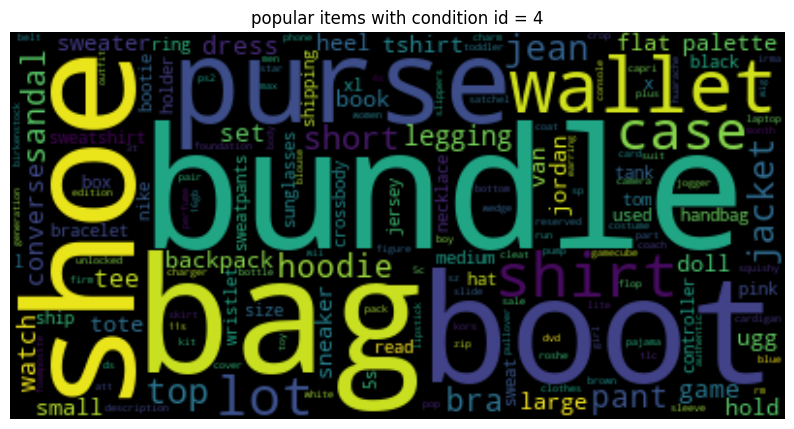

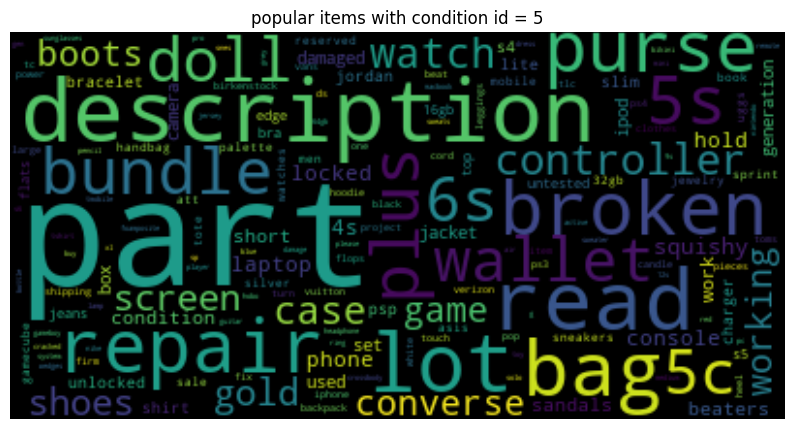

In [66]:
word_cloud_generator(pd.Series(df1.loc[df['item_condition_id'] == 1,'cleaned_name' ]), text = 'popular items with condition id = 1')

word_cloud_generator(pd.Series(df1.loc[df['item_condition_id'] == 2,'cleaned_name' ]), text = 'popular items with condition id = 2')

word_cloud_generator(pd.Series(df1.loc[df['item_condition_id'] == 3,'cleaned_name' ]), text = 'popular items with condition id = 3')

word_cloud_generator(pd.Series(df1.loc[df['item_condition_id'] == 4,'cleaned_name' ]), text = 'popular items with condition id = 4')

word_cloud_generator(pd.Series(df1.loc[df['item_condition_id'] == 5,'cleaned_name' ]), text = 'popular items with condition id = 5')


## Hypothesis testing

#### Does price of the item is similar  for both shipping categories?

H0 : Mean of the prices of products for both shipping type is similar <br>
Ha : Mean of the prices of products for both shipping type is different

<br>
we'll check for 5% significance level

In [67]:
a = df1.loc[df1['shipping'] == 1, 'log_price']
b = df1.loc[df1['shipping'] == 0, 'log_price']

In [68]:
stat_value,p_value = ttest_ind(a,b)

if p_value < 0.05:
    print('reject the null hypothesis (H0) with p-value:',p_value," ,this implies that shipping type  affects the price of product" )
else:
    print('Fail to  reject the null hypothesis (H0) with p-value:',p_value," ,this implies that shipping type doesn't affect the price of product" ) 

reject the null hypothesis (H0) with p-value: 0.0  ,this implies that shipping type  affects the price of product


checking if the price distribution of the different shipping type is same or not?

In [69]:
ks_test(a,b)

distribution are different 0.0


#### Is the item_condition_id depends on the prices of the products

H0 : Prices of products for different condition ids have similar mean <br>
Ha : Prices of products for different condition ids have different mean

<br>
we'll run the hypothesis for 5% significance level.

In [70]:
a = df1.loc[df1['item_condition_id'] == 1, 'log_price']
b = df1.loc[df1['item_condition_id'] == 2, 'log_price']
c = df1.loc[df1['item_condition_id'] == 3, 'log_price']
d = df1.loc[df1['item_condition_id'] == 4, 'log_price']
e = df1.loc[df1['item_condition_id'] == 5, 'log_price']

In [71]:
stat_value,p_value = f_oneway(a,b,c,d,e)

if p_value < 0.05:
    print('reject the null hypothesis (H0) with p-value:',p_value," ,this implies that item condition have impact on the  price of product" )
else:
    print('Fail to  reject the null hypothesis (H0) with p-value:',p_value," ,this implies that item condition don't have any impact on price of product" ) 

reject the null hypothesis (H0) with p-value: 4.753254398164893e-189  ,this implies that item condition have impact on the  price of product


Checking if the price distribution of prices is similar among different item condition ids.

In [72]:
print("for condition id 1 and 2 ", end = '')
ks_test(a,b)

print("for condition id 2 and 3 ", end = '')
ks_test(b,c)

print("for condition id 3 and 4 ", end = '')
ks_test(c,d)

print("for condition id 4 and 5 ", end = '')
ks_test(d,e)


for condition id 1 and 2 distribution are different 5.245351052236512e-303
for condition id 2 and 3 distribution are different 1.8514316065333707e-108
for condition id 3 and 4 distribution are different 4.0828338907289477e-94
for condition id 4 and 5 distribution are different 1.5412268447726136e-27


One can observe that, even the condition ids that are close to each other e.g. 1 and 2, the distribution for price is different.

#### Does items in category of men have similar prices as that of women?

H0 : Mean Price of the items from category of men and women are similar <br>
Ha : Mean Price of the items from category of men and women are different

We'll check again for 5% significance level.

In [73]:
a = df1.loc[df1['categ_1'] == 'men', 'log_price']
b = df1.loc[df1['categ_1'] == 'women', 'log_price']

In [74]:
stat_value,p_value = ttest_ind(a,b)


if p_value < 0.05:
    print('reject the null hypothesis (H0) with p-value:',p_value," ,Mean Price of the items from category of men and women are different" )
else:
    print('Fail to  reject the null hypothesis (H0) with p-value:',p_value," ,Mean Price of the items from category of men and women are similar" ) 

reject the null hypothesis (H0) with p-value: 0.0  ,Mean Price of the items from category of men and women are different


Checking if the price distribution of items in *men* and *women* catergory same?

In [75]:
ks_test(a,b)

distribution are different 4.168045397673192e-306


This show that the price distribution in both categories is different.

#### Is item condition independent of categories? 

H0: item condition and categories are independent <br>
Ha: item condition and categories are not independent

Running statistical test for 5% significance level.

In [76]:
a =  pd.crosstab(index = df1['item_condition_id'], columns = df1['categ_1'])

In [77]:
stat_value,p_value,_,_ = chi2_contingency(a)


if p_value < 0.05:
    print('reject the null hypothesis (H0) with p-value:',p_value," ,item conditions and categories are not independent" )
else:
    print('Fail to  reject the null hypothesis (H0) with p-value:',p_value," ,item conditions and categories are independent" ) 

reject the null hypothesis (H0) with p-value: 0.0  ,item conditions and categories are not independent


## Modelling

### Pre processing

In [78]:
# for faster implementation, we will take fraction of data
df1 = df1.sample(replace = True,frac = 0.2, random_state = 42)

#### Text processing

In [79]:
# integrating the two text columns together.
df1['name_and_item_desc'] = df1['cleaned_name'] +' '+ df1['clean_item_description']


# dropping the text columns : 'cleaned names' and 'clean_item_description'
df1.drop(['cleaned_name','clean_item_description'], axis = 1, inplace = True)

In [80]:
# to remove extra missing from the values caused by concatenation
df1['name_and_item_desc'].loc[df1['name_and_item_desc'] == 'missing missing'] = 'missing'

In [81]:
# tokenization
st = time()

# splitting into words: tokenization 
df1['name_and_item_desc'] = df1['name_and_item_desc'].apply(lambda x: x.split())


en = time()

print('time_taken : ', (en - st)/60,'minutes.')

time_taken :  0.06466659307479858 minutes.


In [82]:
# stemming
st = time()

# stemming 
ps = PorterStemmer()

df1['name_and_item_desc'] = df1['name_and_item_desc'].apply(lambda x:  [ps.stem(i) for i in x] )


en = time()
print('time_taken:',(en - st)/60, ' minutes.')

time_taken: 5.421491972605387  minutes.


In [83]:
# creating list of unqiue words
total_words = []
for i in df1['name_and_item_desc']:
    total_words += i

In [84]:
st = time()
vectorizer  = CountVectorizer()

x1 = vectorizer.fit_transform(total_words)
en  = time()

print('time_taken :',(en - st)/60, ' minutes')

time_taken : 0.7496937235196431  minutes


In [85]:
# numerical vector from text
st = time()
# Create CBOW model
item_and_name_w2v = Word2Vec(total_words, min_count = 5,
                              vector_size = 300, window = 20)
en = time()

print('time taken: ', (en - st)/60,' minutes')

time taken:  2.5425217787424725  minutes


In [86]:
st = time()

# converting the vector
df1['name_and_item_desc2'] = (df1['name_and_item_desc']).apply(sent_to_vec)

print('time_taken: ', (en-st),' minutues.')

time_taken:  -0.027004480361938477  minutues.


In [87]:
# expanding words into features
st = time()

x_name_and_item_desc = (df1["name_and_item_desc2"]).apply(pd.Series)


# dropping columns for feature 'name_and_item_desc'
df1.drop('name_and_item_desc', axis = 1, inplace = True)


en = time()
print('time taken: ', (en - st),' minutes.')

time taken:  80.58926463127136  minutes.


In [88]:
df_new = df1.copy()

In [89]:
df_new.head()

item_condition_id  shipping  log_price  clean_brand_name categ_1   
122537                   1         0   3.091042            gerber    kids  \
674402                   3         1   3.218876               nan   women   
132549                   1         0   2.995732  victorias secret   women   
1421331                  2         0   2.772589   bath body works  beauty   
260431                   1         0   3.828641               nan   women   

           categ_2    categ_3   
122537   boys 2t5t  onepieces  \
674402       shoes      boots   
132549   underwear    panties   
1421331  skin care       body   
260431       jeans   leggings   

                                       name_and_item_desc2  
122537   [-0.0066191046, 0.0070132744, 0.012158418, 0.0...  
674402   [-0.010449565, 0.027860545, 0.02054361, 0.0180...  
132549   [-0.006834741, 0.009032409, 0.010295829, -0.00...  
1421331  [-0.00092833274, 0.017592598, 0.020776706, 0.0...  
260431   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [90]:
df_concat = pd.concat([df_new[['clean_brand_name', 'item_condition_id', 'shipping', 'categ_1',
                   'categ_2', 'categ_3','log_price']],x_name_and_item_desc], axis = 1)


df_concat = df_concat.reset_index()
df_concat.drop('index', axis = 1, inplace = True)
df_concat.head()

# dropping 'name_and_desc2' feature
# df_concat.drop('name_and_item_desc2', inplace = True, axis = 1)

clean_brand_name  item_condition_id  shipping categ_1    categ_2   
0            gerber                  1         0    kids  boys 2t5t  \
1               nan                  3         1   women      shoes   
2  victorias secret                  1         0   women  underwear   
3   bath body works                  2         0  beauty  skin care   
4               nan                  1         0   women      jeans   

     categ_3  log_price         0         1         2  ...       290   
0  onepieces   3.091042 -0.006619  0.007013  0.012158  ...  0.013033  \
1      boots   3.218876 -0.010450  0.027861  0.020544  ...  0.005941   
2    panties   2.995732 -0.006835  0.009032  0.010296  ...  0.013712   
3       body   2.772589 -0.000928  0.017593  0.020777  ...  0.002304   
4   leggings   3.828641  0.000000  0.000000  0.000000  ...  0.000000   

        291       292       293       294       295       296       297   
0 -0.060296 -0.058924 -0.030804 -0.018331 -0.000670 -0.035475 -0.024954  \
1 -0.066791 -0.063825 -0.021112 -0.019568  0.008000 -0.046800 -0.012737   
2 -0.080483 -0.086306 -0.028984 -0.024313  0.000530 -0.049144 -0.050440   
3 -0.054244 -0.056725 -0.015405 -0.015460 -0.003641 -0.037576 -0.012932   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        298       299  
0 -0.013539  0.051139  
1 -0.014656  0.055270  
2 -0.011089  0.059149  
3 -0.018775  0.044435  
4  0.000000  0.000000  

[5 rows x 307 columns]

In [91]:
# changing the dytpe of columns [0,1,2.....299] from int to object

col_list  = ['clean_brand_name', 'item_condition_id', 'shipping', 'categ_1',
                   'categ_2', 'categ_3','log_price']

for i in df_concat.columns[7:]:
    col_list.append('word_' + str(i))

df_concat.columns = col_list


In [92]:
df_concat.head()

clean_brand_name  item_condition_id  shipping categ_1    categ_2   
0            gerber                  1         0    kids  boys 2t5t  \
1               nan                  3         1   women      shoes   
2  victorias secret                  1         0   women  underwear   
3   bath body works                  2         0  beauty  skin care   
4               nan                  1         0   women      jeans   

     categ_3  log_price    word_0    word_1    word_2  ...  word_290   
0  onepieces   3.091042 -0.006619  0.007013  0.012158  ...  0.013033  \
1      boots   3.218876 -0.010450  0.027861  0.020544  ...  0.005941   
2    panties   2.995732 -0.006835  0.009032  0.010296  ...  0.013712   
3       body   2.772589 -0.000928  0.017593  0.020777  ...  0.002304   
4   leggings   3.828641  0.000000  0.000000  0.000000  ...  0.000000   

   word_291  word_292  word_293  word_294  word_295  word_296  word_297   
0 -0.060296 -0.058924 -0.030804 -0.018331 -0.000670 -0.035475 -0.024954  \
1 -0.066791 -0.063825 -0.021112 -0.019568  0.008000 -0.046800 -0.012737   
2 -0.080483 -0.086306 -0.028984 -0.024313  0.000530 -0.049144 -0.050440   
3 -0.054244 -0.056725 -0.015405 -0.015460 -0.003641 -0.037576 -0.012932   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

   word_298  word_299  
0 -0.013539  0.051139  
1 -0.014656  0.055270  
2 -0.011089  0.059149  
3 -0.018775  0.044435  
4  0.000000  0.000000  

[5 rows x 307 columns]

##### Splitting data

In [93]:
X = df_concat.drop('log_price', axis = 1)
y = df_concat['log_price']

In [94]:
#  splitting the data into training
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)


In [95]:
tar_enc = TargetEncoder()

In [96]:
# target encoding

# encoding feature: 'clean_brand_name'

#fitting data
X_train['vec_brand_name'] = tar_enc.fit_transform(X_train['clean_brand_name'], y_train)
# transforming the test data
X_test['vec_brand_name'] = tar_enc.transform(X_test['clean_brand_name'])


# Encoding feature : 'categ_1'

# fitting 
X_train['vec_categ_1'] = tar_enc.fit_transform(X_train['categ_1'], y_train)
# transforming the ttest data
X_test['vec_categ_1'] = tar_enc.transform(X_test['categ_1'])
                                          
#fitting data
X_train['vec_categ_2'] = tar_enc.fit_transform(X_train['categ_2'], y_train)
# transforming the test data
X_test['vec_categ_2'] = tar_enc.transform(X_test['categ_2'])

                                    
#fitting data
X_train['vec_categ_3'] = tar_enc.fit_transform(X_train['categ_3'], y_train)
# transforming the test data
X_test['vec_categ_3'] = tar_enc.transform(X_test['categ_3'])



In [97]:
# dropping the columns with categorical values
X_train.drop(['clean_brand_name','categ_1','categ_2', 'categ_3'], axis = 1, inplace = True)
X_test.drop(['clean_brand_name','categ_1','categ_2', 'categ_3'], axis = 1, inplace = True)

we will use RMSE (Root Mean Square) and R^2 metric for assessing the performance of models.

### 1 Linear Regression with L1 (Lasso) Regularization

We will start the L1 regularization with hyperparametric tuning. For this we will use GridSearchCV and get the best parameters for our final model.

Fitting 3 folds for each of 7 candidates, totalling 21 fits


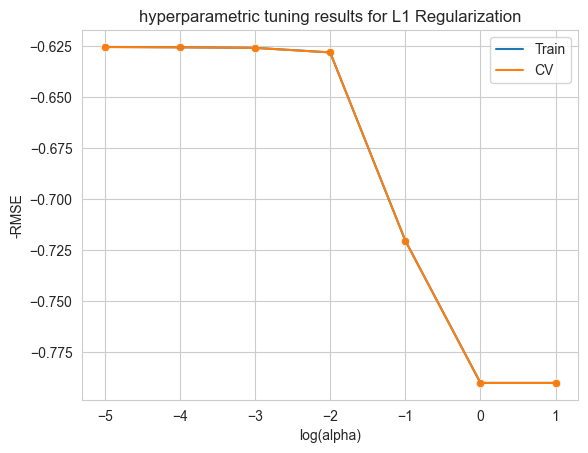

In [98]:
# hyperparametric Tuning
laso = Lasso()
param =  {"alpha":[10**x for x in range(-5,2)]}
reg_l1 = GridSearchCV(laso,param ,cv=3,verbose=1,return_train_score=True,scoring='neg_root_mean_squared_error',n_jobs=-1)
reg_l1.fit(X_train,y_train)

# displaying the results of gridsearchcv
results = pd.DataFrame(reg_l1.cv_results_)
results = results.sort_values(['param_alpha'])

train_score=results["mean_train_score"] 
cv_score=results["mean_test_score"] 

# for scaling we will use log(alpha)
alpha=results["param_alpha"].apply(lambda x:np.log10(x)) 


# plotting
sns.set_style("whitegrid")
sns.lineplot(x=alpha,y=train_score,label="Train")
sns.lineplot(x=alpha,y=cv_score,label="CV")
sns.scatterplot(x=alpha,y=train_score)
sns.scatterplot(x=alpha,y=cv_score)
plt.xlabel("log(alpha)")
plt.ylabel("-RMSE")
plt.legend()
plt.title('hyperparametric tuning results for L1 Regularization')
plt.savefig('hyperparametric tuning results for L1 Regularization', bbox_inches = 'tight')
plt.show()

In [99]:
# best_parameters
reg_l1.best_params_

{'alpha': 1e-05}

In [100]:
# training
laso = Lasso(alpha = 10**-5)
laso.fit(X_train,y_train)

# making predictions
y_pred_l1_test = laso.predict(X_test)

# model performance

# rmse
rmse_l1 = np.sqrt(mean_squared_error(y_test , y_pred_l1_test))
# r^2 score
r2_score_l1 = r2_score(y_test,y_pred_l1_test)

print(rmse_l1, r2_score_l1)

0.6250897880506288 0.37167500535882403


### 2 Linear Regression with L2 (Ridge) Regularization

Fitting 3 folds for each of 10 candidates, totalling 30 fits


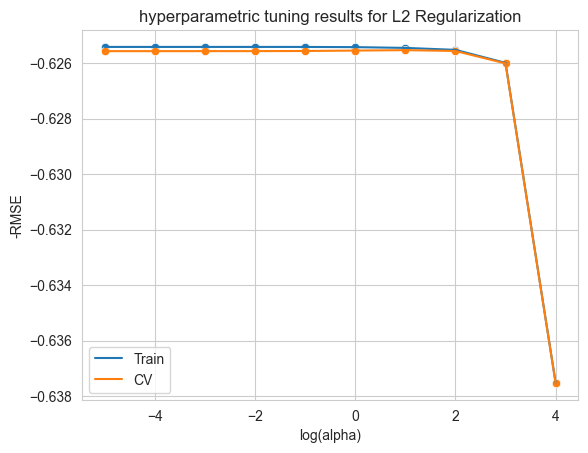

In [101]:
# hyperparameter tuning
ridge = Ridge()
param =  {"alpha":[10**x for x in range(-5,5)]}
reg_l2 = GridSearchCV(ridge,param ,cv=3,verbose=1,return_train_score=True,scoring='neg_root_mean_squared_error',n_jobs=-1)
reg_l2.fit(X_train,y_train)

# displaying the results from GridSearchCV
results = pd.DataFrame(reg_l2.cv_results_)
results = results.sort_values(['param_alpha'])

train_score=results["mean_train_score"] 
cv_score=results["mean_test_score"] 
alpha=results["param_alpha"].apply(lambda x:np.log10(x))


# plotting
sns.set_style("whitegrid")
sns.lineplot(x=alpha,y=train_score,label="Train")
sns.lineplot(x=alpha,y=cv_score,label="CV")
sns.scatterplot(x=alpha,y=train_score)
sns.scatterplot(x=alpha,y=cv_score)
plt.xlabel("log(alpha)")
plt.ylabel("-RMSE")
plt.legend()
plt.title('hyperparametric tuning results for L2 Regularization')
plt.savefig('hyperparametric tuning results for L2 Regularization', bbox_inches = 'tight')
plt.show()

In [102]:
reg_l2.best_params_

{'alpha': 10}

In [103]:
# building model
ridge = Ridge(alpha = 10)

# training
ridge.fit(X_train,y_train)

# prediction
y_pred_l2_test = ridge.predict(X_test)

# performance evaluation 
# RMSE 
rmse_l2 = np.sqrt(mean_squared_error(y_test , y_pred_l2_test))
# R^2 score
r2_score_l2 = r2_score(y_test,y_pred_l2_test)

print(rmse_l2, r2_score_l2)

0.6250764716077464 0.37170177580025476


This model is not performing very well either. R2_score is very small and error is also around 62.6% which is high. Hence, we can say that model's performance is not good enough.

### 3.  Decision Tree Regressor

In [104]:
# hyperparametric tuning

dec_tree = DecisionTreeRegressor(criterion="squared_error",max_features="auto")
param =  {"max_depth":[1,3,5,7,10]}
reg_dt = GridSearchCV(dec_tree,param ,cv=3,verbose=1,return_train_score=True,scoring='neg_root_mean_squared_error',n_jobs=-1)
reg_dt.fit(X_train,y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(max_features='auto'),
             n_jobs=-1, param_grid={'max_depth': [1, 3, 5, 7, 10]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

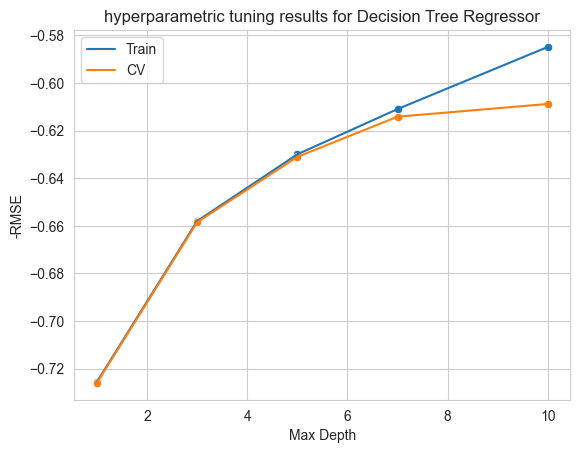

In [105]:
# displaying the results from gridsearchcv
results = pd.DataFrame(reg_dt.cv_results_)
results = results.sort_values(['param_max_depth'])

train_score=results["mean_train_score"] 
cv_score=results["mean_test_score"] 
alpha=results["param_max_depth"]

# plotting
sns.set_style("whitegrid")
sns.lineplot(x=alpha,y=train_score,label="Train")
sns.lineplot(x=alpha,y=cv_score,label="CV")
sns.scatterplot(x=alpha,y=train_score)
sns.scatterplot(x=alpha,y=cv_score)
plt.xlabel("Max Depth")
plt.ylabel("-RMSE")
plt.legend()
plt.title('hyperparametric tuning results for Decision Tree Regressor')
plt.savefig('hyperparametric tuning results for Decision Tree Regressor', bbox_inches = 'tight')
plt.show()

In [106]:
# best parameter
print('best_parametr: ', reg_dt.best_params_)

best_parametr:  {'max_depth': 10}


In [107]:
# building model
reg_dt = DecisionTreeRegressor(max_depth = 10)

# training the model with this parameter
reg_dt.fit(X_train,y_train)

# making prediction
y_pred_dt_test = reg_dt.predict(X_test)


# performance evaluation

#RMSE
rmse_dt = np.sqrt(mean_squared_error(y_test , y_pred_dt_test))
# r2_score
r2_score_dt = r2_score(y_test,y_pred_dt_test)

print(rmse_dt, r2_score)

0.6023307495149165 <function r2_score at 0x0000019380C94160>


### 4. Histogram Based Gradient Boosting Regressor

In [108]:
# hyperparametric tuning

h_gbr = HistGradientBoostingRegressor(random_state = 42)
param =  {"max_depth":[5,10,15,20]}
reg_hgbr = GridSearchCV(h_gbr, param, cv = 3, verbose = 1, return_train_score = True, scoring = 'neg_root_mean_squared_error', n_jobs = -1 )
reg_hgbr.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=HistGradientBoostingRegressor(random_state=42),
             n_jobs=-1, param_grid={'max_depth': [5, 10, 15, 20]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

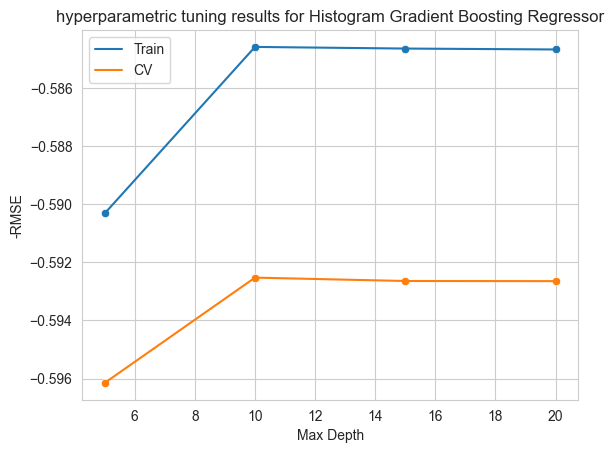

In [109]:
# displaying the results from gridsearchcv
results = pd.DataFrame(reg_hgbr.cv_results_)
results = results.sort_values(['param_max_depth'])

train_score=results["mean_train_score"] 
cv_score=results["mean_test_score"] 
alpha=results["param_max_depth"]

# plotting
sns.set_style("whitegrid")
sns.lineplot(x=alpha,y=train_score,label="Train")
sns.lineplot(x=alpha,y=cv_score,label="CV")
sns.scatterplot(x=alpha,y=train_score)
sns.scatterplot(x=alpha,y=cv_score)
plt.xlabel("Max Depth")
plt.ylabel("-RMSE")
plt.legend()
plt.title('hyperparametric tuning results for Histogram Gradient Boosting Regressor')
plt.savefig('hyperparametric tuning results for Histogram Gradient Boosting Regressor', bbox_inches = 'tight')
plt.show()

In [110]:
# best parameter
print('best_parametr: ', reg_hgbr.best_params_)

best_parametr:  {'max_depth': 10}


In [111]:
# building model
reg_hgbr = HistGradientBoostingRegressor(max_depth = 20)

# training the model with this parameter
reg_hgbr.fit(X_train,y_train)

# making prediction
y_pred_hgbr_test = reg_dt.predict(X_test)


# performance evaluation

#RMSE
rmse_hgbr = np.sqrt(mean_squared_error(y_test , y_pred_hgbr_test))
# r2_score
r2_score_hgbr = r2_score(y_test,y_pred_hgbr_test)

print(rmse_hgbr, r2_score_hgbr)

0.6023307495149165 0.41659573741208844


### Comparing model performances

In [112]:
model_perf_df = pd.DataFrame(columns = ['model','Root mean sq error','R^2 score'])

In [113]:
model_perf_df['model'] = ['linear_reg with L1 regularization','linear_reg with L2 regularization','Decision Tree Rregressor','Histogram Gradient Boosting Regressor']
model_perf_df['Root mean sq error'] = [rmse_l1 , rmse_l2, rmse_dt, rmse_hgbr]
model_perf_df['R^2 score'] = [r2_score_l1, r2_score_l2, r2_score_dt,r2_score_hgbr]

In [114]:
model_perf_df

model  Root mean sq error  R^2 score
0      linear_reg with L1 regularization            0.625090   0.371675
1      linear_reg with L2 regularization            0.625076   0.371702
2               Decision Tree Rregressor            0.602331   0.416596
3  Histogram Gradient Boosting Regressor            0.602331   0.416596

Decision Tree Regressor performed relatively better as compare to linear regression models with regularization

#### Conclusion

We need better approaches in order to build better models that are more faster and will be able to predict prices better.
We also need a better approach for text data. 